<a href="https://colab.research.google.com/github/yonigresearch-wq/ML-workflows/blob/main/MLCB_Post_hoc_explanations_and_Graph_Neural_Networks_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Advanced Topics in Machine Learning for Computational Biology

## Homework 2: Antimicrobial Property prediction with tree ensembles and graph neural networks


Figure and data from: A Deep Learning Approach to Antimicrobial Discovery, Stokes et al. Cell 2020.


 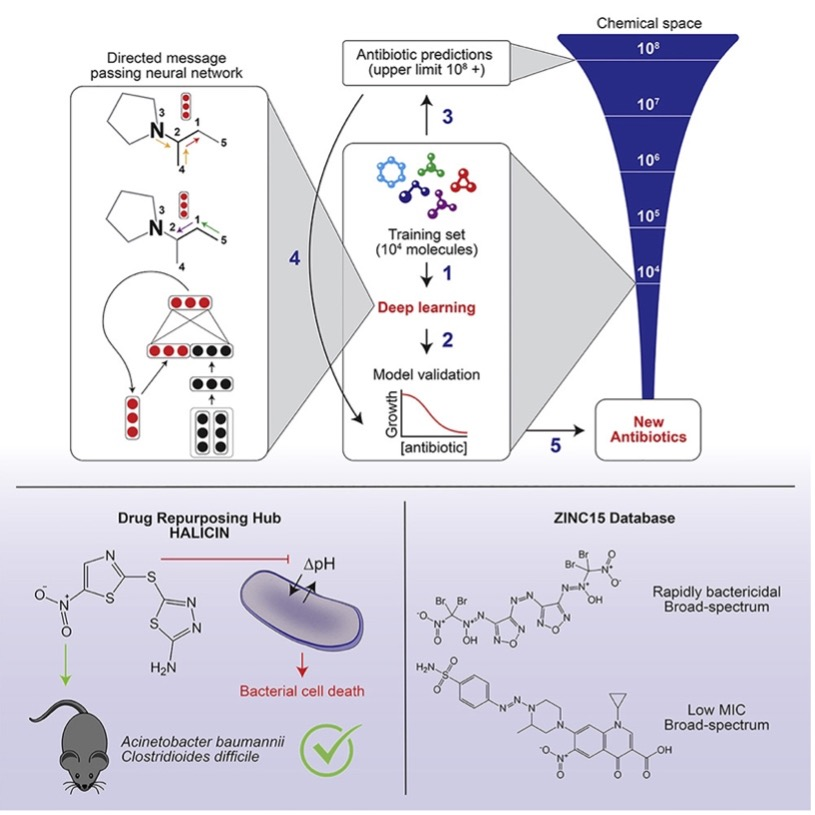





## Download data & install packages

In [ ]:
!wget https://github.com/jertubiana/jertubiana.github.io/raw/master/misc/MLCB_2024_HW2_Data.zip
!unzip /content/MLCB_2024_HW2_Data.zip
!pip install matplotlib seaborn shap torch_geometric rdkit

--2025-07-19 08:34:01--  https://github.com/jertubiana/jertubiana.github.io/raw/master/misc/MLCB_2024_HW2_Data.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jertubiana/jertubiana.github.io/master/misc/MLCB_2024_HW2_Data.zip [following]
--2025-07-19 08:34:02--  https://raw.githubusercontent.com/jertubiana/jertubiana.github.io/master/misc/MLCB_2024_HW2_Data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1683460 (1.6M) [application/zip]
Saving to: ‘MLCB_2024_HW2_Data.zip’

MLCB_2024_HW2_Data. 100%[===================>]   1.61M  --.-KB/s    in 0.04s   

2025-07-19 08:34:02 (42.4 MB/s) - ‘

# Package & data loading

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from rdkit import Chem

table_first_round_molecules   =  pd.read_excel( '/content/MLCB_2024_HW2_Data/training_table.xlsx',skiprows=1,sheet_name='S1B')

table_first_round_molecules['Class_Label'] = table_first_round_molecules['Activity'].map(lambda x: 1 if x=='Active' else 0)

print( 'Training table') # This dataset was collected in the first experimental round and will be used for training/evaluating the performance of our model.
display(table_first_round_molecules.head())


table_evaluation_molecules = pd.read_excel('/content/MLCB_2024_HW2_Data/DrugRepurposing_Hub_predictions.xlsx',skiprows=1,sheet_name='S2B').drop(columns=['Unnamed: 6','Broad_ID'])
print( 'Evaluation table') # This dataset was used for screening candidates in the second experimental round. We will use it for inference only.
display(table_evaluation_molecules.head())


Training table


,Mean_Inhibition,SMILES,Name,Activity,Class_Label
0,0.041572,Cc1cc(O)c(C(=O)NC(C(=O)NC2C(=O)N3C(C(=O)O)=C(C...,CEFPIRAMIDE,Active,1
1,0.041876,CON=C1CN(c2nc3c(cc2F)c(=O)c(C(=O)O)cn3C2CC2)CC...,GEMIFLOXACIN MESYLATE,Active,1
2,0.041916,CCC(C)CCCCC(=O)NC(CCN)C(=O)NC(C(=O)NC(CCN)C(=O...,POLYMYXIN B SULFATE,Active,1
3,0.041964,Cl.N=C(N)n1cccn1,PRAXADINE HYDROCHLORIDE,Active,1
4,0.042295,Cl.Cl.N=C(NCCCCCCNC(=N)NC(=N)Nc1ccc(Cl)cc1)NC(...,CHLORHEXIDINE DIHYDROCHLORIDE,Active,1


Evaluation table


,Name,SMILES,Pred_Score,Mean_Inhibition,ClinTox (low = less predicted toxicity)
0,cefmenoxime,CO\N=C(\C(=O)NC1C2SCC(CSc3nnnn3C)=C(N2C1=O)C(O...,0.967200,0.04505,0.001422
1,ulifloxacin,CC1Sc2c(C(O)=O)c(=O)c3cc(F)c(cc3n12)N1CCNCC1,0.957037,0.05040,0.958267
2,cefotiam,CN(C)CCn1nnnc1SCC1=C(N2[C@H](SC1)[C@H](NC(=O)C...,0.952527,0.04495,0.229829
3,ceftriaxone,CO\N=C(/C(=O)N[C@H]1[C@H]2SCC(CSc3nc(=O)c(O)nn...,0.942160,0.04250,0.011146
4,balofloxacin,CNC1CCCN(C1)c1c(F)cc2c(c1OC)n(cc(C(O)=O)c2=O)C...,0.931109,0.04115,0.927147


# Part 0: Parsing the data into Tabular Machine Learning format using the RDKIT package

In this section we:
- Convert each SMILE into a RDKIT Molecule class instance, which has many useful methods.

- Calculate various physio-chemical features for each molecule using RDKIT pre-provided functions. Example of features include number of atoms and bonds of each type, number of hydrogen bond donor and acceptors, etc.


In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, Crippen, MolSurf
import numpy as np


def extract_chemical_features(list_molecules):
  def num_atoms(mol):
    atom_counts = {
        'Total': 0,
        'Carbon': 0,
        'Nitrogen': 0,
        'Oxygen': 0,
        'Sulfur': 0,
        'Fluorine': 0,
        'Phosphate':0,
        'Chlorine':0,
        'Other':0,
    }
    for atom in mol.GetAtoms():
      atom_counts['Total'] +=1
      atom_type = atom.GetSymbol()
      if atom_type == 'C':
          atom_counts['Carbon'] += 1
      elif atom_type == 'N':
          atom_counts['Nitrogen'] += 1
      elif atom_type == 'O':
          atom_counts['Oxygen'] += 1
      elif atom_type == 'S':
          atom_counts['Sulfur'] += 1
      elif atom_type == 'F':
          atom_counts['Fluorine'] += 1
      elif atom_type == 'P':
          atom_counts['Phosphate'] += 1
      elif atom_type == 'Cl':
          atom_counts['Chlorine'] += 1
      else:
          atom_counts['Other'] += 1
    return atom_counts


  def num_bonds(mol):
    bond_counts = {
        'Total': 0,
        'Single': 0,
        'Double': 0,
        'Triple': 0,
        'Aromatic': 0,
    }
    # Iterate through all bonds in the molecule
    for bond in mol.GetBonds():
      bond_counts['Total'] +=1
      bond_type = bond.GetBondType()
      if bond_type == Chem.BondType.SINGLE:
          bond_counts['Single'] += 1
      elif bond_type == Chem.BondType.DOUBLE:
          bond_counts['Double'] += 1
      elif bond_type == Chem.BondType.TRIPLE:
          bond_counts['Triple'] += 1
      elif bond_type == Chem.BondType.AROMATIC:
          bond_counts['Aromatic'] += 1
    return bond_counts


  """
  Extract chemical features for a list of molecules.

  Parameters:
  list_molecules (list): List of small molecules (RDKIT class instances).
  Returns:
  pandas.DataFrame: Table of descriptors.
  """

  # List to store results
  results = []

  # Define descriptors to compute (MOE-like)
  descriptors = {
      'MolWt': Descriptors.MolWt,  # Molecular weight
      'LogP': Crippen.MolLogP,     # Octanol-water partition coefficient
      'TPSA': MolSurf.TPSA,        # Topological polar surface area
      'HBD': Lipinski.NumHDonors,  # Number of hydrogen bond donors
      'HBA': Lipinski.NumHAcceptors,  # Number of hydrogen bond acceptors
      'RotBonds': Lipinski.NumRotatableBonds,  # Number of rotatable bonds
      'NumAromRings': Descriptors.NumAromaticRings,  # Number of aromatic rings
      'NumHeteroatoms': Descriptors.NumHeteroatoms,  # Number of heteroatoms
      'FractionSP3': Descriptors.FractionCSP3,  # Fraction of sp3 carbons
      'MolarRefractivity': Crippen.MolMR,  # Molar refractivity (MOE's mr)
      'NumAtoms': num_atoms,
      'NumBonds': num_bonds,
  }

  all_mol_features = []
  for molecule in list_molecules:
    mol_features = {}
    for desc_name, desc_func in descriptors.items():
      results = desc_func(molecule)
      if isinstance(results,dict):
        for key, value in results.items():
          mol_features[f'{desc_name}{key}'] = value
      else:
        mol_features[desc_name] = results
    all_mol_features.append(mol_features)
  return pd.DataFrame(all_mol_features)




# SMILES is a string-based representation of molecules.
first_round_molecules_smiles = table_first_round_molecules['SMILES']
evaluation_molecules_smiles = table_evaluation_molecules['SMILES']

# We first turn each molecule into an instance of the RDKIT molecule.
first_round_molecules_rdkit = [Chem.MolFromSmiles(smiles) for smiles in first_round_molecules_smiles]
evaluation_molecules_rdkit = [Chem.MolFromSmiles(smiles) for smiles in evaluation_molecules_smiles]

# Discard examples for which conversion failed.
first_round_molecules_success = [i for i in range(len(first_round_molecules_rdkit)) if first_round_molecules_rdkit[i] is not None]
evaluation_molecules_success = [i for i in range(len(evaluation_molecules_rdkit)) if evaluation_molecules_rdkit[i] is not None]

print(f'Molecule construction failed for { len(first_round_molecules_rdkit)-len(first_round_molecules_success) }/{len(first_round_molecules_rdkit)} examples in the first round dataset')
print(f'Molecule construction failed for {len(evaluation_molecules_rdkit) - len(evaluation_molecules_success)}/{len(evaluation_molecules_rdkit)} examples in the evaluation dataset')

table_first_round_molecules = table_first_round_molecules.iloc[first_round_molecules_success].reset_index()
table_evaluation_molecules = table_evaluation_molecules.iloc[evaluation_molecules_success].reset_index()

first_round_molecules_rdkit = [mol for mol in first_round_molecules_rdkit if mol is not None]
evaluation_molecules_rdkit = [mol for mol in evaluation_molecules_rdkit if mol is not None]


features_first_round_molecules = extract_chemical_features(first_round_molecules_rdkit)
features_first_round_molecules.index = table_first_round_molecules['Name']

features_evaluation_molecules = extract_chemical_features(evaluation_molecules_rdkit)
features_evaluation_molecules.index = table_evaluation_molecules['Name']

print('Example of descriptors for 10 molecules')
display(features_first_round_molecules.head())






[08:34:29] Explicit valence for atom # 16 Al, 6, is greater than permitted


Molecule construction failed for 1/2335 examples in the first round dataset
Molecule construction failed for 0/4496 examples in the evaluation dataset
Example of descriptors for 10 molecules


,MolWt,LogP,TPSA,HBD,HBA,RotBonds,NumAromRings,NumHeteroatoms,FractionSP3,MolarRefractivity,...,NumAtomsSulfur,NumAtomsFluorine,NumAtomsPhosphate,NumAtomsChlorine,NumAtomsOther,NumBondsTotal,NumBondsSingle,NumBondsDouble,NumBondsTriple,NumBondsAromatic
Name,,,,,,,,,,,,,,,,,,,,,
CEFPIRAMIDE,612.650,0.32672,212.76,5,13,9,3,17,0.280000,148.1593,...,2,0,0,0,0,46,24,5,0,17
GEMIFLOXACIN MESYLATE,485.494,0.47000,177.41,3,10,5,2,14,0.473684,117.8653,...,1,1,0,0,0,35,19,5,0,11
POLYMYXIN B SULFATE,1301.578,-5.89760,565.26,20,20,29,1,34,0.696429,330.3537,...,1,0,0,0,0,90,71,13,0,6
PRAXADINE HYDROCHLORIDE,146.581,0.04647,67.69,2,3,0,1,5,0.000000,36.7871,...,0,0,0,1,0,8,2,1,0,5
CHLORHEXIDINE DIHYDROCHLORIDE,578.380,5.01888,167.58,10,4,9,2,14,0.272727,156.2970,...,0,0,0,4,0,35,19,4,0,12


# Part I: Exploratory Data Analysis

1.	Display, as a scatter plot, the distribution of the number of atoms and covalent bonds per molecule. Color by the measured  class. Is there a relationship between molecule size and activity?

In [ ]:
# Organize data for plots

## Set molecule names as indices

table_first_round_molecules = table_first_round_molecules.set_index('Name')

## Sort both tables by index

features_first_round_molecules = features_first_round_molecules.sort_index()
table_first_round_molecules = table_first_round_molecules.sort_index()

## Add class label to features table using aligned index

features_first_round_molecules['Class_Label'] = table_first_round_molecules['Class_Label']


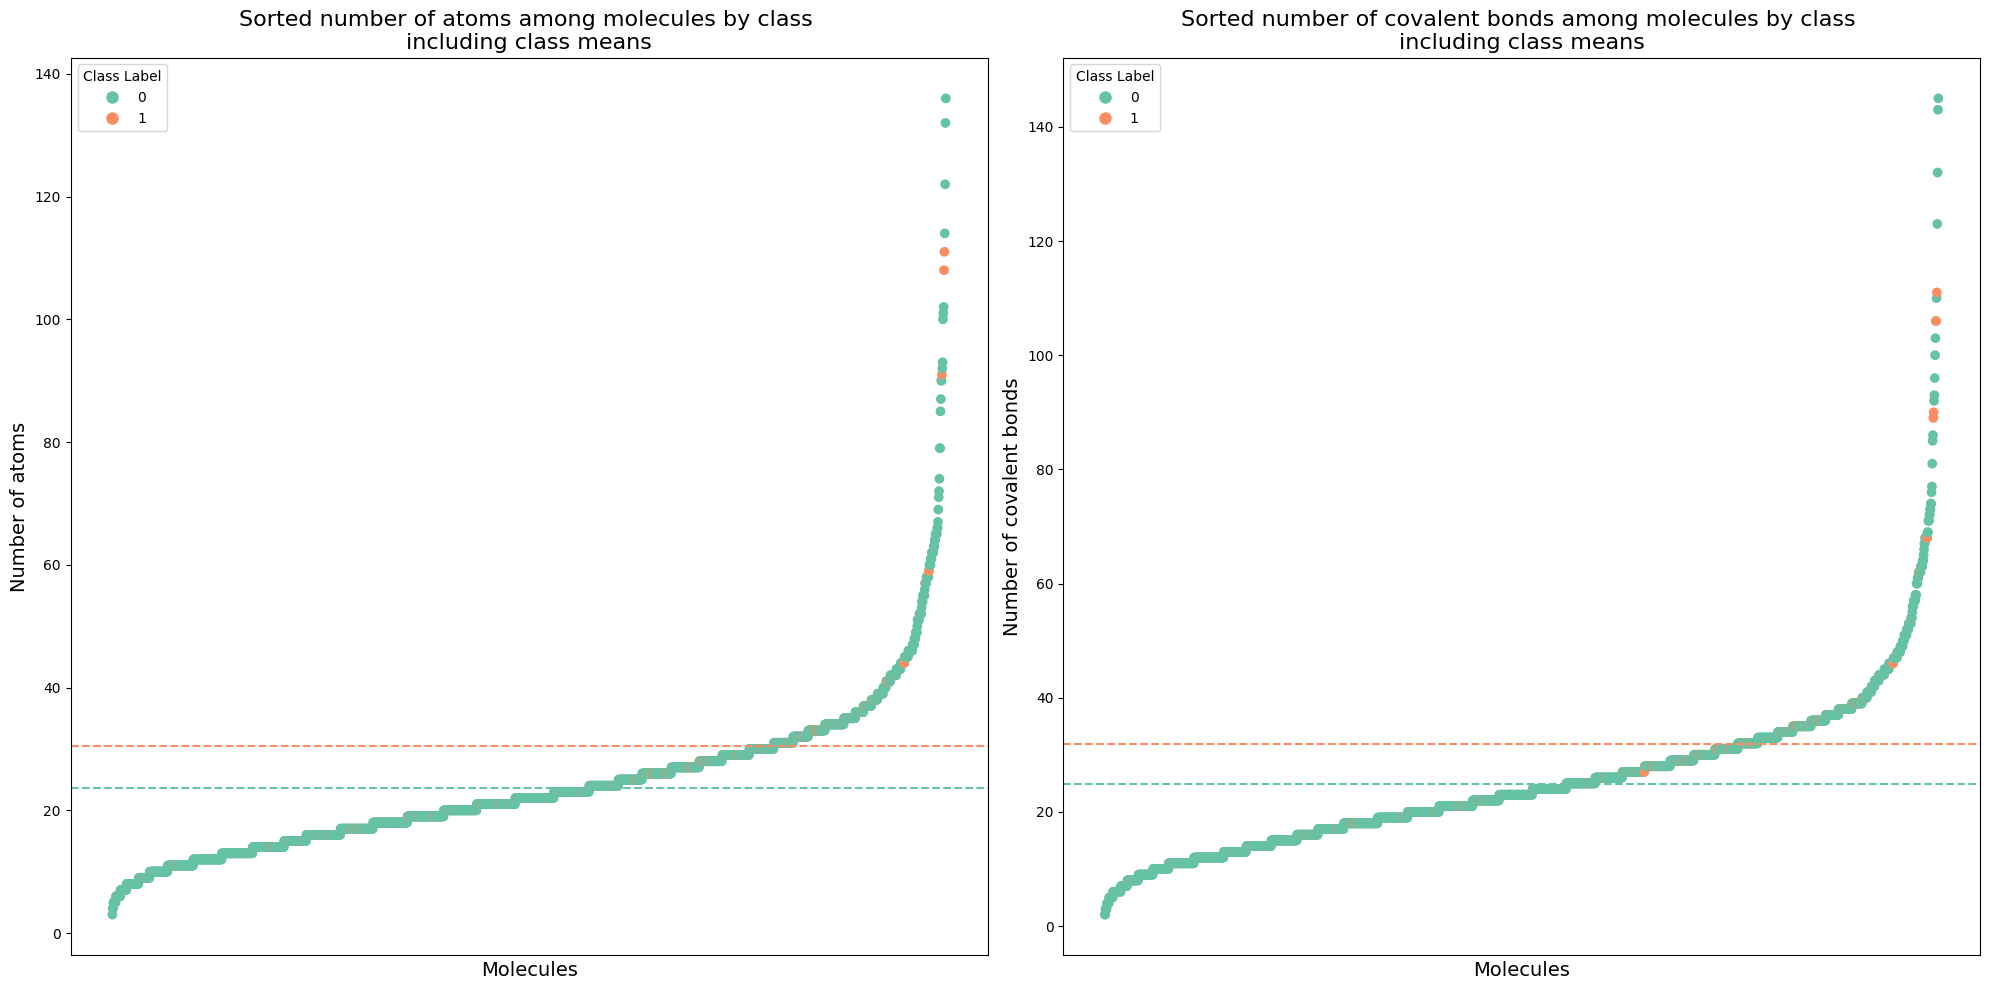

In [ ]:
# Relevant tools

from matplotlib.lines import Line2D

# Create scatter plots

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

## Color map and legend labels by class

unique_classes = features_first_round_molecules['Class_Label'].unique()
palette = sns.color_palette('Set2', len(unique_classes))
color_dict = dict(zip(unique_classes, palette))

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=class_i,
           markerfacecolor=color_dict[class_i], markersize=10)
    for class_i in unique_classes
]

## Sort the values for plots

sorted_atoms = features_first_round_molecules[['NumAtomsTotal', 'Class_Label']].sort_values(by='NumAtomsTotal').reset_index(drop=True)
sorted_bonds = features_first_round_molecules[['NumBondsTotal', 'Class_Label']].sort_values(by='NumBondsTotal').reset_index(drop=True)

color_atoms = sorted_atoms['Class_Label'].map(color_dict)
color_bonds = sorted_bonds['Class_Label'].map(color_dict)

## Calculate means by class

class_means_atoms = sorted_atoms.groupby('Class_Label')['NumAtomsTotal'].mean()
class_means_bonds = sorted_bonds.groupby('Class_Label')['NumBondsTotal'].mean()

## Number of atoms plot

ax = axes[0]
ax.scatter(range(len(sorted_atoms)),
           sorted_atoms['NumAtomsTotal'],
           c=color_atoms)
ax.set_title('Sorted number of atoms among molecules by class \nincluding class means', fontsize=16)
ax.set_xlabel('Molecules', fontsize=14)
ax.set_ylabel('Number of atoms', fontsize=14)
ax.set_xticks([])
ax.legend(handles=legend_elements, title='Class Label', loc='upper left')

for class_i in unique_classes:
    mean_val = class_means_atoms[class_i]
    ax = axes[0]
    ax.axhline(mean_val, color=color_dict[class_i], linestyle='--', linewidth=1.5,
               label=f'{class_i} mean')

## Number of bonds plot

ax = axes[1]
ax.scatter(range(len(sorted_bonds)),
           sorted_bonds['NumBondsTotal'],
           c=color_bonds)
ax.set_title('Sorted number of covalent bonds among molecules by class \nincluding class means', fontsize=16)
ax.set_xlabel('Molecules', fontsize=14)
ax.set_ylabel('Number of covalent bonds', fontsize=14)
ax.set_xticks([])
ax.legend(handles=legend_elements, title='Class Label', loc='upper left')

for class_i in unique_classes:
    mean_val = class_means_bonds[class_i]
    ax = axes[1]
    ax.axhline(mean_val, color=color_dict[class_i], linestyle='--', linewidth=1.5,
               label=f'{class_i} mean')

plt.tight_layout()
plt.show()


2.	For each of the following five features:
*   Octanol-water partition coefficient
*   Molecular weight
*   Number of hydrogen bond donors
*   Number of hydrogen bond acceptors
*   Number of aromatic rings


Display the histogram of the feature value, for each of the two classes. Which feature(s) have the strongest discriminative power?


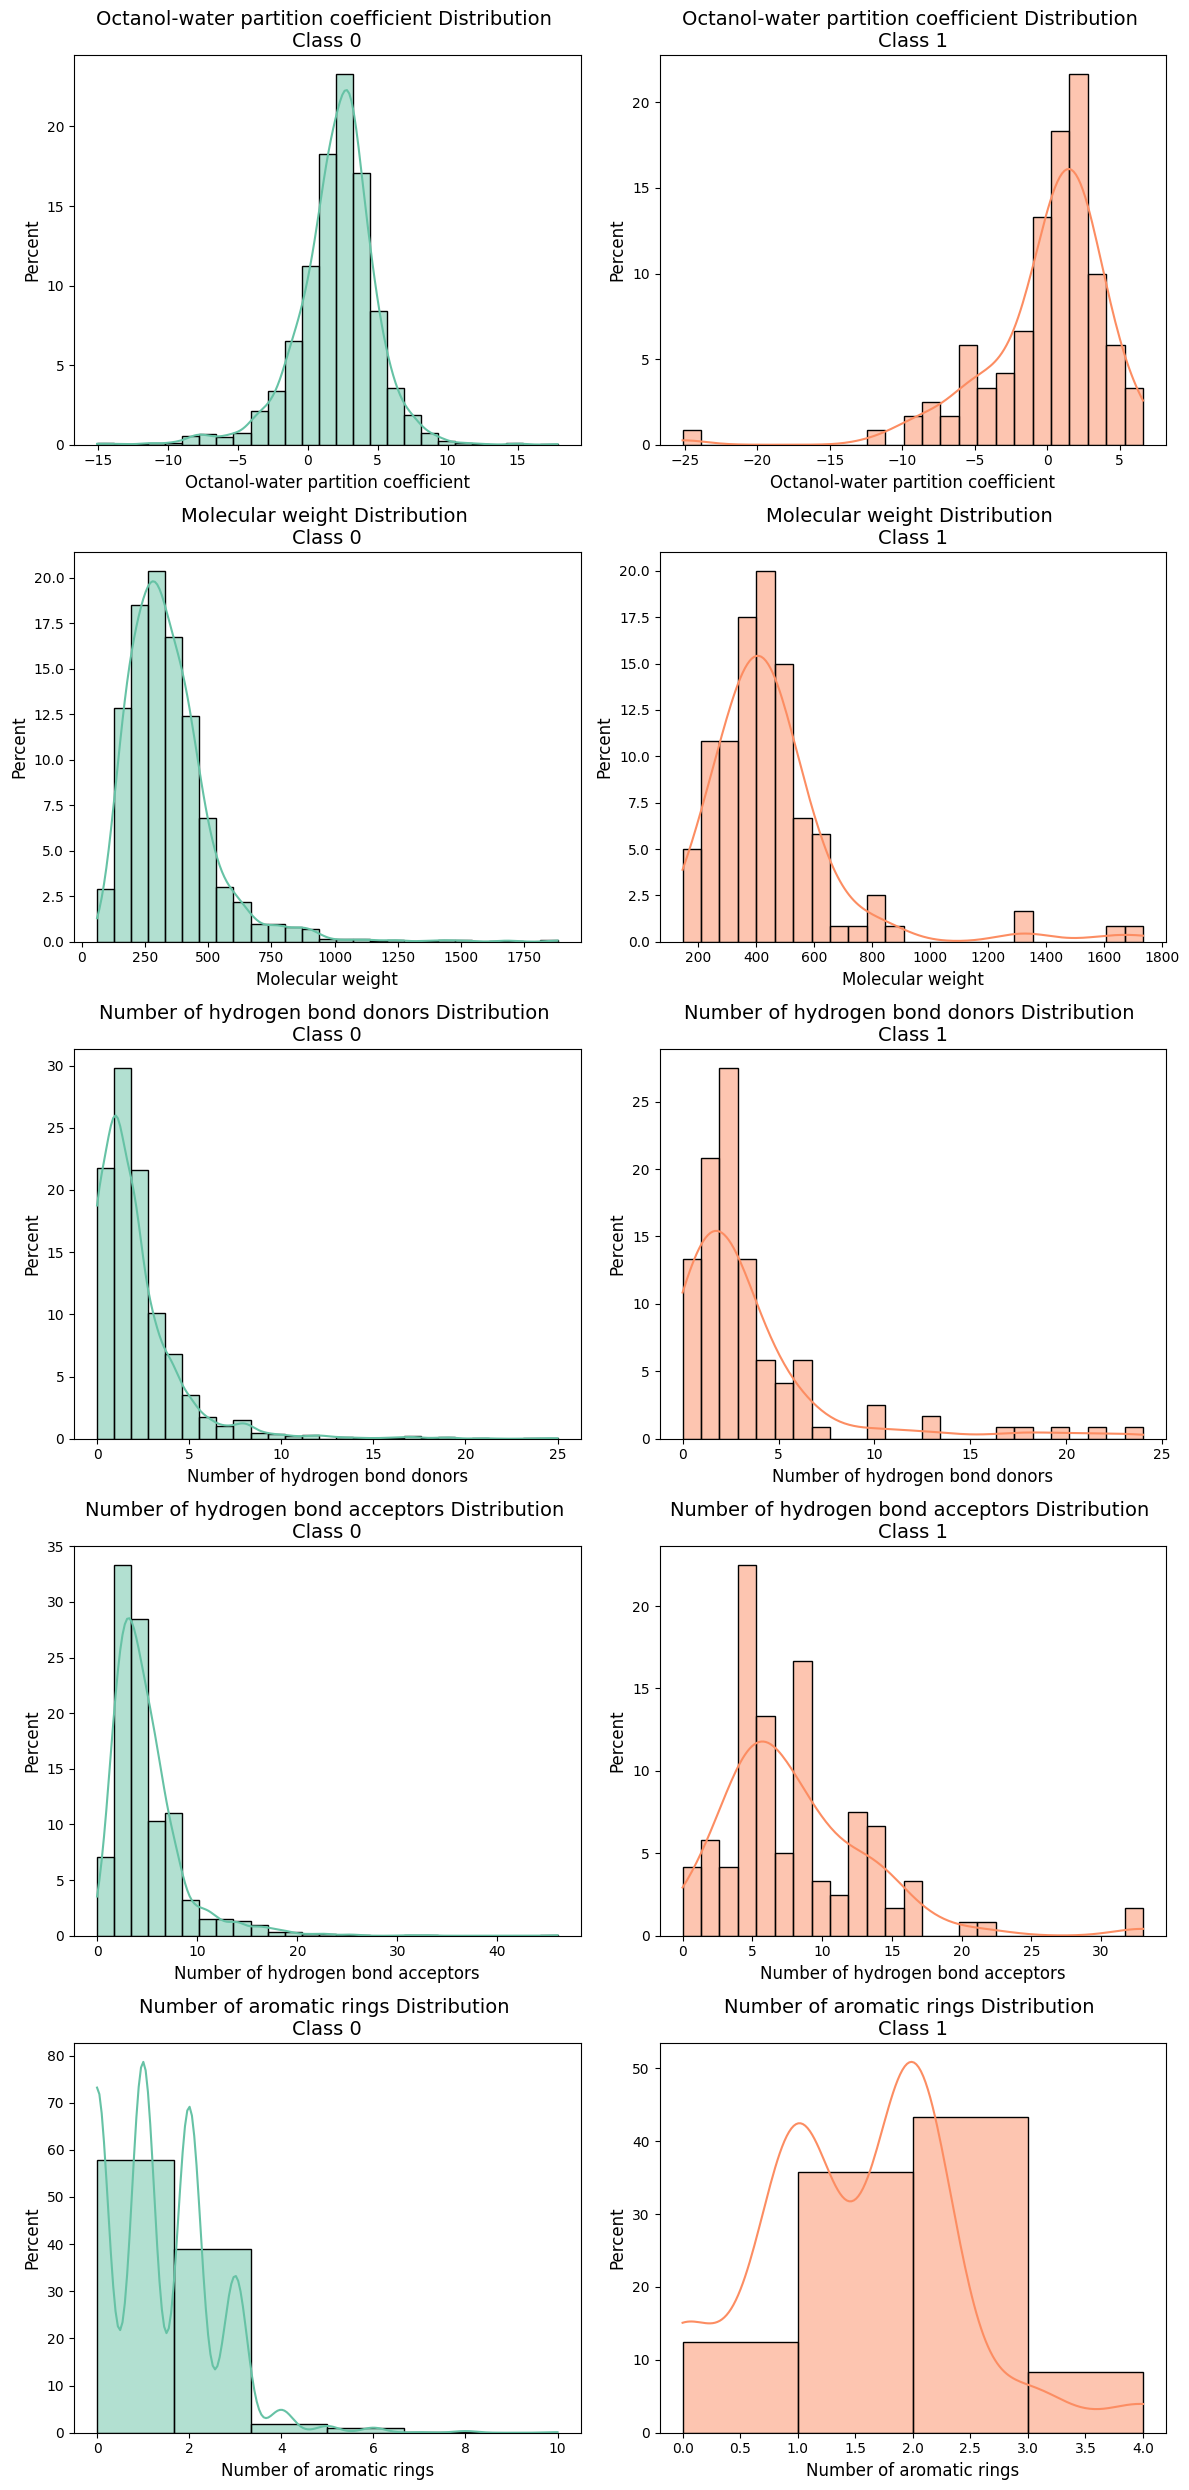

In [ ]:
Feature_list = ['LogP', 'MolWt', 'HBD', 'HBA', 'NumAromRings']
plot_title_names = ['Octanol-water partition coefficient',
                    'Molecular weight',
                    'Number of hydrogen bond donors',
                    'Number of hydrogen bond acceptors',
                    'Number of aromatic rings']
Bins = [25, 25, 25, 25, 4]

fig, axes = plt.subplots(len(Feature_list), 2, figsize=(12, 25))  # wider for 2 plots per row

for i, feature in enumerate(Feature_list):

    feature_name = plot_title_names[i]

    # Subset for class 0 and class 1
    data_class0 = features_first_round_molecules[features_first_round_molecules['Class_Label'] == 0]
    data_class1 = features_first_round_molecules[features_first_round_molecules['Class_Label'] == 1]

    # Left column: class 0
    ax0 = axes[i, 0]
    sns.histplot(
        data=data_class0,
        x=feature,
        color=color_dict[0],
        ax=ax0,
        element="bars",
        stat="percent",
        bins=Bins[i]+2,
        kde=True
    )

    ax0.set_title(f'{feature_name} Distribution \nClass 0', fontsize=14)
    ax0.set_xlabel(feature_name, fontsize=12)
    ax0.set_ylabel('Percent', fontsize=12)

    # Right column: class 1
    ax1 = axes[i, 1]
    sns.histplot(
        data=data_class1,
        x=feature,
        color=color_dict[1],
        ax=ax1,
        element="bars",
        stat="percent",
        bins=Bins[i],
        kde=True
    )
    ax1.set_title(f'{feature_name} Distribution \nClass 1', fontsize=14)
    ax1.set_xlabel(feature_name, fontsize=12)
    ax1.set_ylabel('Percent', fontsize=12)

plt.tight_layout()
plt.show()

# drop class variable from feature data

features_first_round_molecules = features_first_round_molecules.drop(columns=['Class_Label'])



### **Conclusion**

Class 1 molecules seem to have more atoms and more covalent bonds. This most likely implies that they are longer than class 0 molecules.

By exammining the histograms of the 5 plotted variables, I conclude the variabe which provides the best distiction between class 0 and class 1 molecules is **Molecular weight** - class 1 molecules have larger average molecule weight - distribution shapes are similar. This aligns with the higher number of atoms and hydrogen bonds in class 1 molecules.







# Part II: Data Partition

Our training data is NOT independently distributed because many known antimicrobial molecules were obtained by small modifications of previously known molecules. Indeed, similar molecules often have similar chemical activity. We thus need to partition the data with grouped splits.


Specifically, our goal is to build a model that can generalize well to unseen molecules. To this end, we want to make sure that our molecules from the train, validation and test are “dissimilar enough”.


We will use the Tanimoto similarity, a custom metric for calculating similarity between molecules (from 0 = dissimilar to 1 = maximally similar).



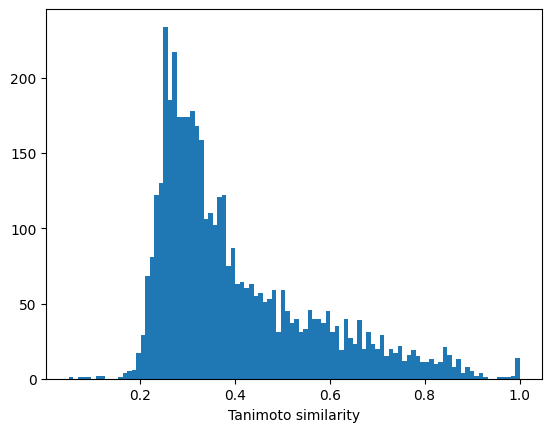

Selected Tanimoto similarity Cut-off: 0.34
Created 477 groups
86 34


In [ ]:
from rdkit.Chem import AllChem, DataStructs
from scipy.sparse import csr_array
from scipy.sparse.csgraph import connected_components
from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold
from rdkit.Chem import rdFingerprintGenerator


def calculate_morgan_fingerprints(list_molecules, radius=2, fpSize=1024):
  '''
  A count-based representation of small molecules (e.g., how many occurence of O with double bond to C, etc.)
  '''
  mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius,fpSize=fpSize)
  fingerprints = [mfpgen.GetFingerprint(mol) for mol in list_molecules]
  return fingerprints


def calculate_tanimoto_similarity(fp1,fp2):
    """
    Calculate the Tanimoto similarity between two molecules given their Morgan fingerprints.

    Parameters:
    fp1 (str): Morgan Fingerprints of the first molecule.
    fp2 (str): Morgan Fingerprints of the second molecule.

    Returns:
    float: Tanimoto similarity score (0 to 1), or None if invalid SMILES.
    """
    return DataStructs.TanimotoSimilarity(fp1, fp2)



first_round_molecules_morgan_fingerprints = calculate_morgan_fingerprints(first_round_molecules_rdkit)
evaluation_molecules_morgan_fingerprints = calculate_morgan_fingerprints(evaluation_molecules_rdkit)


nFirstRoundMols = len(first_round_molecules_rdkit)
nEvaluationMols = len(evaluation_molecules_rdkit)


tanimoto_similarities_first_round = np.zeros([nFirstRoundMols,nFirstRoundMols])


## Calculate Tanimoto similarities within set of molecules from first round.
for i in range(nFirstRoundMols):
  for j in range(i+1,nFirstRoundMols):
    tanimoto_similarities_first_round[i,j] = calculate_tanimoto_similarity(first_round_molecules_morgan_fingerprints[i],first_round_molecules_morgan_fingerprints[j])
    tanimoto_similarities_first_round[j,i] = tanimoto_similarities_first_round[i,j]


## Calculate Tanimoto similarities between set of molecules from first round and set from second round.


tanimoto_similarities_evaluation_to_first_round = np.zeros([nEvaluationMols,nFirstRoundMols])
for i in range(nEvaluationMols):
  for j in range(nFirstRoundMols):
    tanimoto_similarities_evaluation_to_first_round[i,j] = calculate_tanimoto_similarity(evaluation_molecules_morgan_fingerprints[i],first_round_molecules_morgan_fingerprints[j])


## Explain this code section for Q4/5.

similarity_to_closest_labeled_molecule = tanimoto_similarities_evaluation_to_first_round.max(axis=1)
plt.hist(similarity_to_closest_labeled_molecule,bins=100)
plt.xlabel('Tanimoto similarity')
plt.show()

tanimoto_cut_off = np.median(similarity_to_closest_labeled_molecule)
print(f'Selected Tanimoto similarity Cut-off: {tanimoto_cut_off:.2f}')


binary_similarity_graph = tanimoto_similarities_first_round >= tanimoto_cut_off
n_groups, groups = connected_components(csgraph=csr_array(binary_similarity_graph), directed=False, return_labels=True)

print(f'Created {n_groups} groups')


train_test_split = GroupShuffleSplit(n_splits=1,test_size=0.2,random_state=0)
[(train_and_val_index, test_index)] = train_test_split.split(features_first_round_molecules,table_first_round_molecules['Class_Label'],groups)


## Use this train/val split for training the GNN.
train_val_split = GroupShuffleSplit(n_splits=1,test_size=0.2, random_state=0)
[(train_index, val_index)] = train_val_split.split(features_first_round_molecules.iloc[train_and_val_index],table_first_round_molecules['Class_Label'].iloc[train_and_val_index],groups[train_and_val_index])

X_data = features_first_round_molecules.iloc[train_and_val_index]
y_data = table_first_round_molecules['Class_Label'].iloc[train_and_val_index]
groups_data = groups[train_and_val_index]

X_train_val = features_first_round_molecules.iloc[train_and_val_index]
y_train_val = table_first_round_molecules['Class_Label'].iloc[train_and_val_index]

X_test = features_first_round_molecules.iloc[test_index]
y_test = table_first_round_molecules['Class_Label'].iloc[test_index]

print(len(y_train_val[y_train_val == 1]), len(y_test[y_test == 1]))


In [ ]:

# I spereated the 5-fold CV splits from the rest of the code and added a code snippet which varifies that
# all validation sets have at least a few class 1 molecule

## Use this 5-fold cross-validation for training and evaluating the feature-based model.
## Note that I only used thos for the xgboost model

max_attempts = 10000
attempt = 0
found_valid_split = False

X_data = features_first_round_molecules.iloc[train_and_val_index]
y_data = table_first_round_molecules['Class_Label'].iloc[train_and_val_index]
groups_data = groups[train_and_val_index]

while attempt < max_attempts and not found_valid_split:
    attempt += 1
    cross_val_split = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=183 + attempt)  # change seed per try
    cv_indices = list(cross_val_split.split(X_data, y_data, groups=groups_data))

    # Check all validation folds for at least 3 class 1s in each fold
    all_folds_valid = True
    for fold, (train_idx, val_idx) in enumerate(cv_indices):
        y_val_fold = y_data.iloc[val_idx]
        if y_val_fold.sum() < 3:
            all_folds_valid = False
            break

    if all_folds_valid:
        found_valid_split = True
        print(f"Valid split found after {attempt} attempt(s):")
        for fold, (train_idx, val_idx) in enumerate(cv_indices):
            y_train_fold = y_data.iloc[train_idx]
            y_val_fold = y_data.iloc[val_idx]
            print(f"Fold {fold+1}: Train positives = {y_train_fold.sum()}, Validation positives = {y_val_fold.sum()}")

if not found_valid_split:
    print(f"Failed to find a valid split with positives in all validation folds after {max_attempts} attempts.")


Valid split found after 279 attempt(s):
Fold 1: Train positives = 98, Validation positives = 11
Fold 2: Train positives = 25, Validation positives = 84
Fold 3: Train positives = 102, Validation positives = 7
Fold 4: Train positives = 105, Validation positives = 4
Fold 5: Train positives = 106, Validation positives = 3


3.	Justify the choice of threshold used for Tamimoto similarity.

### **Justification of cut-off choice**

0.34 is the chosen cut-off value, which is obtained by taking the median of the maximal Tamimoto similarity between evaluation molecules and the training molecules. This choice makes sence because approx. half of the molecules will be similar while half of the molecules with be more diverse compared to the reference molecule. This is a blanced approach, which helps us make sure that the groups we create based on this threshold, are not too diverse or to homogenious.


4.	Explain how the algorithm prevents two molecules with high Tamimoto similarity from ending up in the same split.

### **Guranteed Same partition assignment to similar molecules**

After choosing the cut-off, we construct an undirected binary graph (undirected because similarity is symmetric) (essentially a matrix 1s and 0s), where each training (first round) molecule is a node, with an edge connecting between molecules with Tamimoto similarity larger $≥$ 0.34. This provides us with a strategy to group molecules, based on the network of molecules their connected to. According to the output, we obtain a total of 477 groups. When partitioning the data (into validation-test, or splitting the validation data into 5 folds), we provide the splitting algorithm with the group indecies for each molecule, which guarantees that the connected molecules will be assigned the same split.

# Part III: Training a tree ensemble model on the Dataset.

5.	 Throughout the rest of the homework, the metric for model selection and evaluation is chosen to be the Area under the Precision Recall Curve (implemented as the “average_precision_score” in sklearn). Justify this choice of metric given the problem considered.


### **Justification of the model selection metric**

The use of the Area under the Precision Recall Curve(AUPRC), as its name implies, allows us to take into account both model *Precision:*

$$
\hat{Pr}(True \, Positive \,|\,Positive \ Classification)
$$

and *Recall:*

$$
\hat{Pr}(Positive \ Classification \,|\,True \, Positive)
$$

This is extremely important in the context of classifying moleculer properties. As we saw in class, many molecular properties (such as toxicity) that we are intrested in predicting, can be rare and much less frequent then their complementary property. In these cases, a (not so good) model, can achieve high accuracy by simply predicting the mode class.
AUPRC however averages precision over various recall levels, which helps us better estimate model performance.


6.	Using sklearn’s HistGradBoosting (or xgboost/LightGBM), build a Gradient Boosted Tree classifier. Select the optimal hyperparameters (number of iterations; learning rate; regularization strength; number of leaves) by cross-validation using the provided group split. Calculate the precision-recall curve over the test set, display it and report the AUCPR. Comment on the quality of the predictions.

**Tuning the xgboost model**

In order to decrease to the computation of the tuning process, I decided to first tune the number of iterations and learning rate, and then use the optimal combination to further tune other hyperparameters.  

In [ ]:
# Import relevant tools

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score as APS
from xgboost import XGBRFClassifier as XGB

splits = cv_indices

# Define grid parameters for first round of tuning

n_trees = [100, 500, 1000, 5000, 10000]
eta = [0.01, 0.001, 0.0005]

# Step 1: Tune n_estimators and learning_rate

XGB_model_step1 = XGB(eval_metric='aucpr')
pipeline_step1 = Pipeline([('XGB', XGB_model_step1)])

param_grid_step1 = {
    "XGB__n_estimators": n_trees,
    "XGB__learning_rate": eta,
}

grid_search_step1 = GridSearchCV(
    estimator=pipeline_step1,
    param_grid=param_grid_step1,
    cv=splits,
    scoring="average_precision",
    return_train_score=True
)

X_train_val = features_first_round_molecules.iloc[train_and_val_index]
y_train_val = table_first_round_molecules['Class_Label'].iloc[train_and_val_index]

grid_search_step1.fit(X_train_val, y_train_val)

# Step 1 results

step_1_results = {
    "Optimal # trees": grid_search_step1.best_params_['XGB__n_estimators'],
    "Optimal learning rate": grid_search_step1.best_params_['XGB__learning_rate'],
    "Mean Cross-Validation AUCPR": grid_search_step1.best_score_
}

step_1_table = pd.DataFrame([step_1_results])
step_1_table


,Optimal # trees,Optimal learning rate,Mean Cross-Validation AUCPR
0,500,0.0005,0.292156


In [ ]:

# Define grid parameters for 2'nd round of tuning

opt_n_trees = grid_search_step1.best_params_['XGB__n_estimators']
opt_eta = grid_search_step1.best_params_['XGB__learning_rate']

max_d = [2, 4, 6]
sub_samp = [0.3, 0.5, 0.8, 1]
lambda_param = [0, 1, 10]
alpha_param = [0, 1, 10]

# Step 2: Tune more hyperparameters using base parameters from step 1

XGB_model_step2 = XGB(n_estimators=opt_n_trees, learning_rate=opt_eta, eval_metric='logloss')
pipeline_step2 = Pipeline([('XGB', XGB_model_step2)])

param_grid_step2 = {
    "XGB__max_depth": max_d,
    "XGB__subsample": sub_samp,
    "XGB__reg_lambda": lambda_param,
    "XGB__alpha": alpha_param,
}

grid_search_step2 = GridSearchCV(
    estimator=pipeline_step2,
    param_grid=param_grid_step2,
    cv=splits,
    scoring="average_precision",
    return_train_score=True
)

grid_search_step2.fit(X_train_val, y_train_val)

## Evaluation on the test set using optimal parameters

best_XGB_model = grid_search_step2.best_estimator_

X_test = features_first_round_molecules.iloc[test_index]
y_test = table_first_round_molecules['Class_Label'].iloc[test_index]

y_test_pred_probs = best_XGB_model.predict_proba(X_test)[:, 1]

AUCPR_test = APS(y_test, y_test_pred_probs)

## Final results

step_2_results = {
    "Optimal # trees": opt_n_trees,
    "Optimal learning rate": opt_eta,
    "Optimal max depth": grid_search_step2.best_params_['XGB__max_depth'],
    "Optimal subsample": grid_search_step2.best_params_['XGB__subsample'],
    "Optimal lambda (L2 reg)": grid_search_step2.best_params_['XGB__reg_lambda'],
    "Optimal alpha (L1 reg)": grid_search_step2.best_params_['XGB__alpha'],
    "AUCPR on Test Set": AUCPR_test
}

step_2_table = pd.DataFrame([step_2_results])
step_2_table


,Optimal # trees,Optimal learning rate,Optimal max depth,Optimal subsample,Optimal lambda (L2 reg),Optimal alpha (L1 reg),AUCPR on Test Set
0,500,0.0005,6,0.5,0,0,0.558275


We can visulaize the performance of our model by plotting the precision-recall curve:

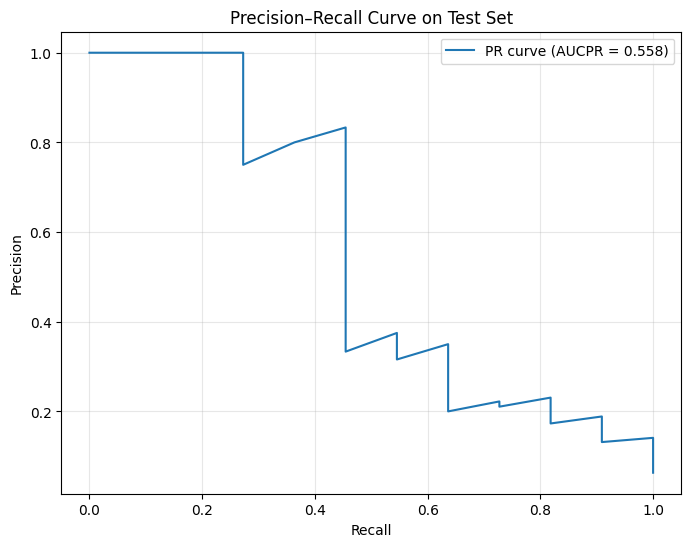

In [ ]:
# Import relevant tools

from sklearn.metrics import precision_recall_curve

# Compute precision-recall curve

precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (AUCPR = {AUCPR_test:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve on Test Set')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### **Quality of Predictions**

The model's predictions remain limited. As shown in the precision-recall curve, achieving high precision inevitably comes at the cost of low recall, and vice versa. The optimal trade-off lies somewhere in the middle, meaning we must compromise on both recall and precision. As a result, the model yields relatively high rates of both false positives and false negatives.

In conclusion, even after hyperparameter tuning, the model fails to achieve good separability between class 1 and class 0 molecules. This suggests that the a tree-ensemble model is not sufficient for predicting anti-microbial activity (well).

# Part IV: Post-hoc explanations of the tree ensemble model

7.	Using sklearn, calculate the feature importance using the Permutation Feature Importance metric over the train and test set. Which features are the most informative?

In [ ]:
# Import relevant tools

from sklearn.inspection import permutation_importance

# Training data

## Extract permutation importance for train set

perm_importance_train = permutation_importance(
    best_XGB_model, X_train_val, y_train_val,
    scoring="average_precision",
    n_repeats=30,
    random_state=42
)

## Convert to data frame and sort

feature_names = X_train_val.columns

importance_train = pd.DataFrame({
    'feature': feature_names,
    'mean_importance': perm_importance_train.importances_mean,
    'importance_sd': perm_importance_train.importances_std
})

importance_train = importance_train.sort_values(by='mean_importance', ascending=False)

# Test data

## Extract permutation importance for test set

perm_importance_test = permutation_importance(
    best_XGB_model, X_test, y_test,
    scoring="average_precision",
    n_repeats=30,
    random_state=42
)

## Convert to data frame and sort

importance_test = pd.DataFrame({
    'feature': feature_names,
    'mean_importance': perm_importance_test.importances_mean,
    'importance_sd': perm_importance_test.importances_std
})

importance_test = importance_test.sort_values(by='mean_importance', ascending=False)


In [ ]:
# First lets see what the most informative variables are

print("Permutation Feature Importance for Training Data - Top 10 Features\n")
print(importance_train.head(10))

print("\n\nPermutation Feature Importance for Test Data - Top 10 Features\n")
print(importance_test.head(10))


Permutation Feature Importance for Training Data - Top 10 Features

             feature  mean_importance  importance_sd
15  NumAtomsFluorine         0.170377       0.012743
7     NumHeteroatoms         0.102611       0.015220
1               LogP         0.096171       0.012730
12  NumAtomsNitrogen         0.052055       0.018002
5           RotBonds         0.048584       0.006009
17  NumAtomsChlorine         0.032041       0.003494
23  NumBondsAromatic         0.031524       0.010280
8        FractionSP3         0.021984       0.006240
2               TPSA         0.020502       0.005263
13    NumAtomsOxygen         0.015033       0.003699


Permutation Feature Importance for Test Data - Top 10 Features

             feature  mean_importance  importance_sd
12  NumAtomsNitrogen         0.160041       0.044713
15  NumAtomsFluorine         0.159777       0.060623
7     NumHeteroatoms         0.106297       0.047565
1               LogP         0.104030       0.048096
17  NumAtomsChlori

8.	Using sklearn, display the Partial Dependence Plots (PDP) for the 10 most important features, ordered by importance. Comment on the findings.

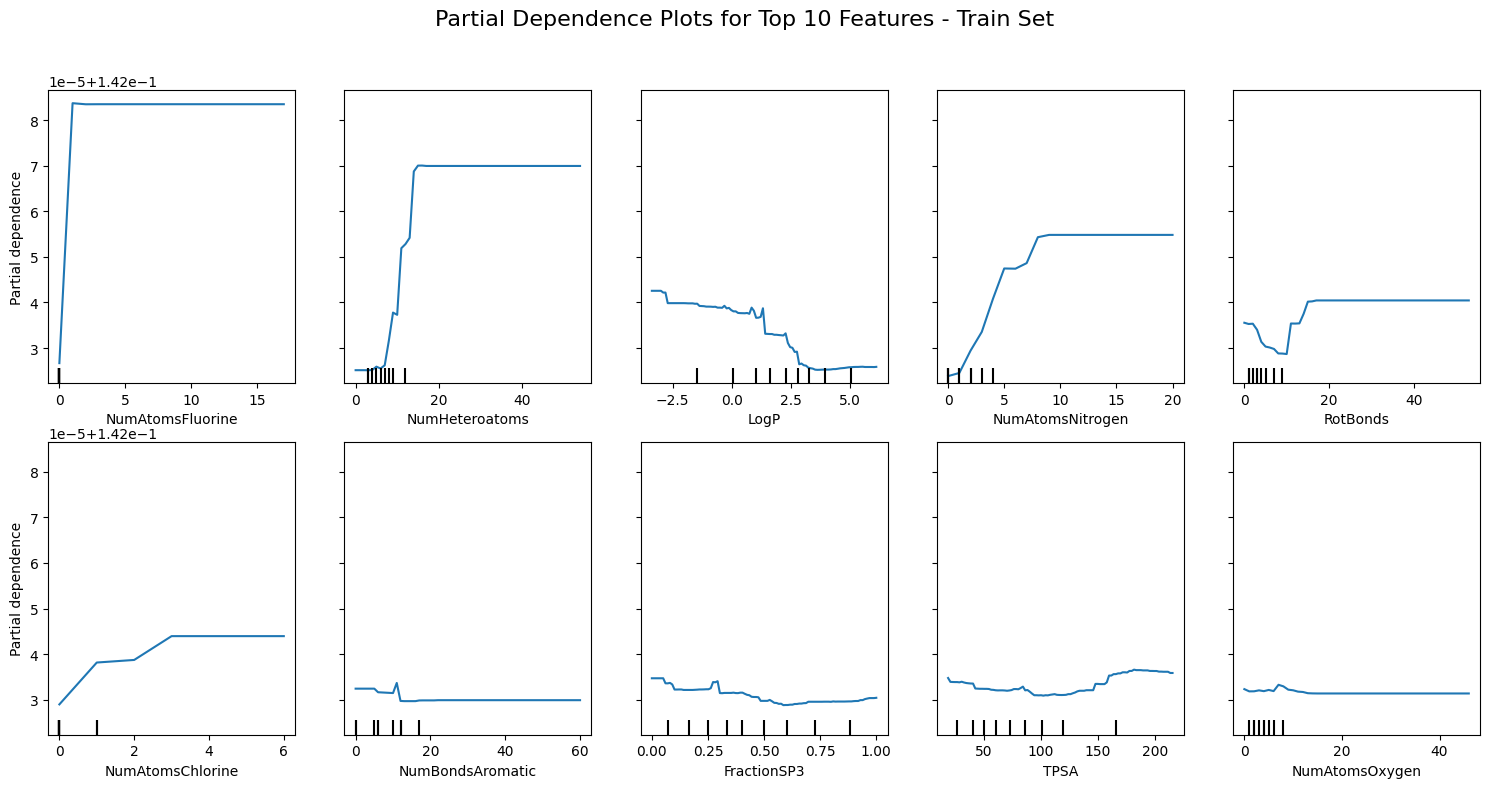

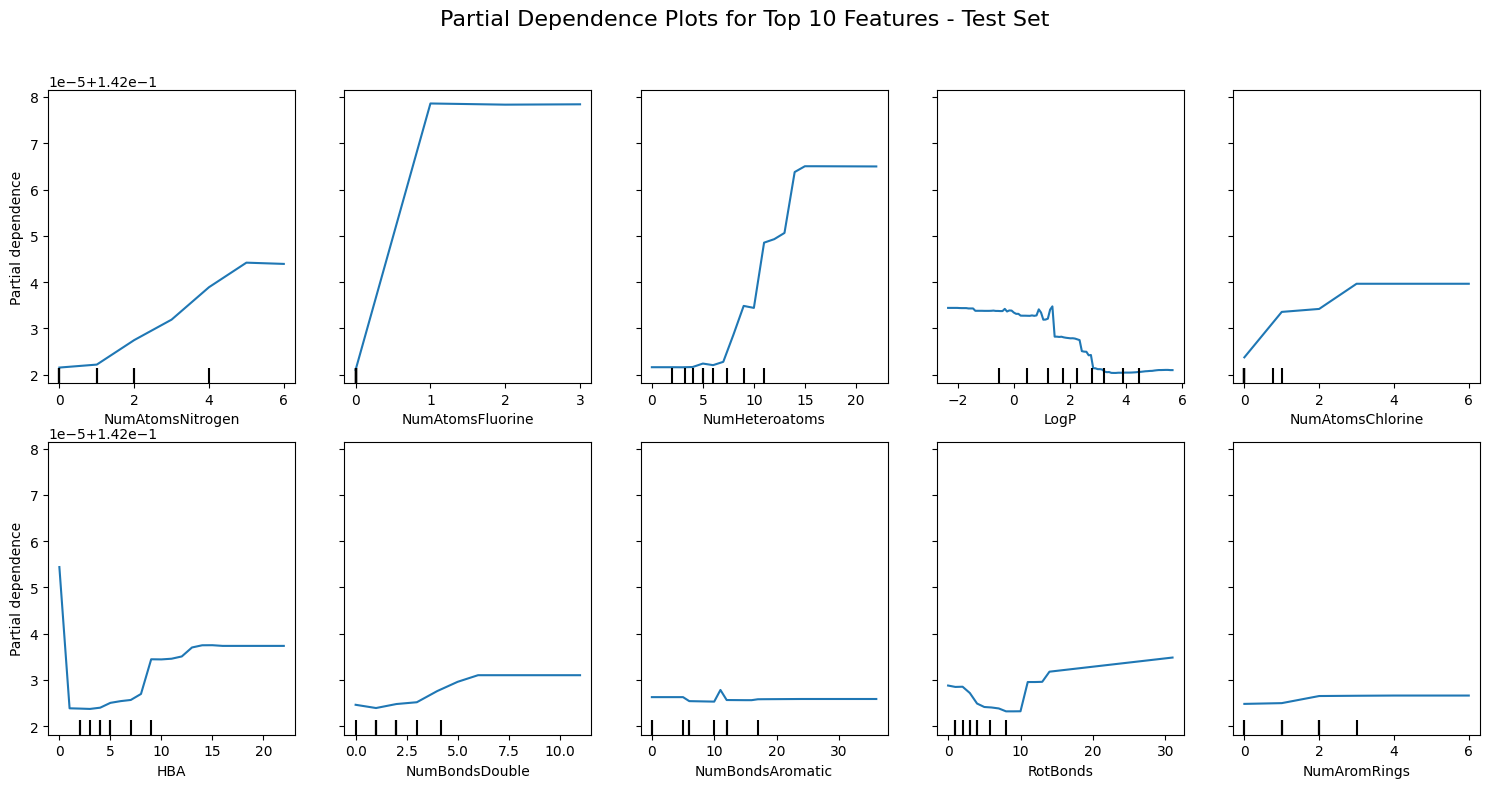

In [ ]:
# Import relevant tools

from sklearn.inspection import PartialDependenceDisplay

# Training data

top_10_train = importance_train['feature'].head(10).tolist()

fig, ax = plt.subplots(figsize=(15, 8))

PartialDependenceDisplay.from_estimator(
    best_XGB_model,
    X_train_val,
    features=top_10_train,
    kind="average",
    n_cols=5,
    ax=ax)

plt.suptitle('Partial Dependence Plots for Top 10 Features - Train Set', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Test data

top_10_test = importance_test['feature'].head(10).tolist()

fig, ax = plt.subplots(figsize=(15, 8))

PartialDependenceDisplay.from_estimator(
    best_XGB_model,
    X_test,
    features=top_10_test,
    kind="average",
    n_cols=5,
    ax=ax)

plt.suptitle('Partial Dependence Plots for Top 10 Features - Test Set', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### **Explination of the Partial Dependence Plots**

First note that top 10 features among the train and test sets have 7 features in common (in slightly diferent order). These features also have similar trends for both training and test.

***Key Insights (for Top 5 Features in the Test Set)***

- The number of Nitrogen atoms has a clear positive correlation with the prediction probability of class 1 molecules.

- The presence of Fluorine is critical for classification - this is evident from the sharp increase between 0-1 followed by a flat effect for values larger than 1.

- Number of Heteroatoms has a clear positive association when above a ceratin threshold (approximatly 7 or 8)

- The octanol-water partition coefficient also seems to be important - it shows a overall negative correlation with prediction of class 1 molecules.

- Number of chlorine atoms shows more of a stepwise positive association with classification as class 1.


9.	Predict the activity of Halicin (SMILE representation: Nc1nnc(Sc2ncc([N+](=O)[O-])s2)s1),  Amoxicilin (SMILE representation: CC1(C)SC2C(NC(=O)C(N)c3ccc(O)cc3)C(=O)N2C1C(=O)O) and calculate the Shapley values associated to these prediction using shap. Are they predicted to be active and why?

In [ ]:
# Use the predefined functions to exctract molecule properties
# I used chatgpt to help with this part

mols_to_predict = {
    ' Halicin': 'Nc1nnc(SCc2nccs2)s1',
    'Amoxicillin': 'CC1(C)SC2C(NC(=O)C(N)c3ccc(O)cc3)C(=O)N2C1C(=O)O'
}

new_mols_rdkit = {name: Chem.MolFromSmiles(smiles) for name, smiles in mols_to_predict.items()}

for name, mol in new_mols_rdkit.items():
    if mol is None:
        print(f"⚠️ Molecule construction failed for: {name}")
    else:
        print(f"✅ Molecule constructed: {name}")


mols_to_predict = [mol for mol in new_mols_rdkit.values() if mol is not None]
new_features = extract_chemical_features(mols_to_predict)
new_features.index = list(new_mols_rdkit.keys())

# Top 5 feature in terms of permutation importance

pd.DataFrame({'Logp': new_features['LogP'],
            'NumAtomsNitrogen': new_features['NumAtomsNitrogen'],
            'NumAtomsFluorine': new_features['NumAtomsFluorine'],
            'NumHeteroatoms': new_features['NumHeteroatoms'],
            'NumAtomsChlorine': new_features['NumAtomsChlorine']})


✅ Molecule constructed:  Halicin
✅ Molecule constructed: Amoxicillin


,Logp,NumAtomsNitrogen,NumAtomsFluorine,NumHeteroatoms,NumAtomsChlorine
Halicin,1.8691,4,0,7,0
Amoxicillin,0.0237,3,0,9,0


 Halicin: Predicted activity = 0
Amoxicillin: Predicted activity = 0

SHAP values for  Halicin:


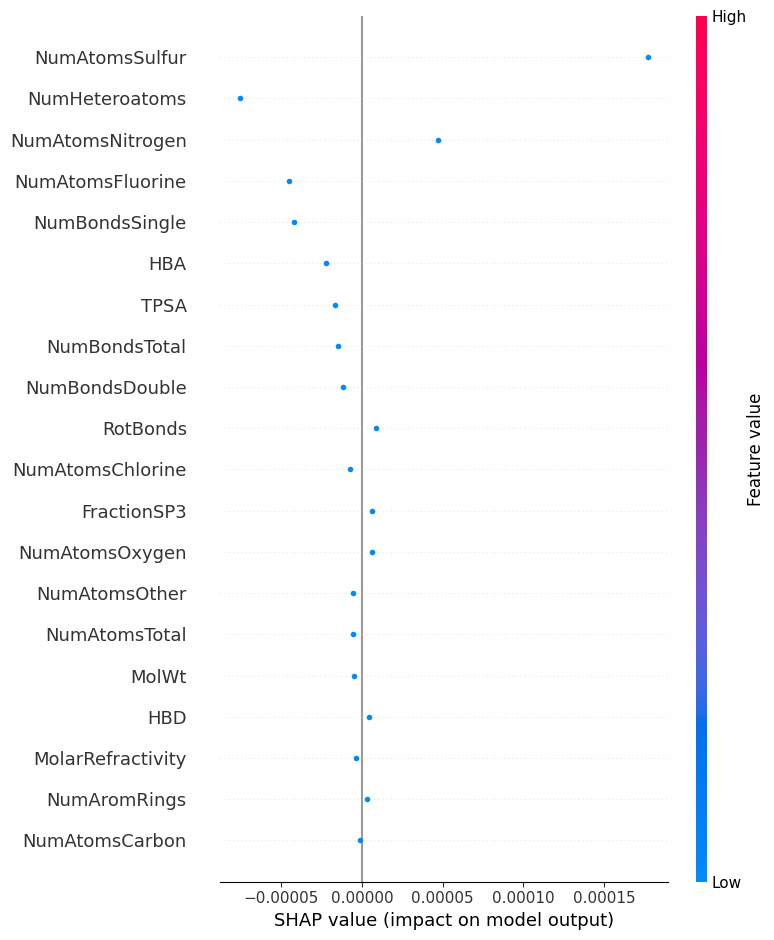


SHAP values for Amoxicillin:


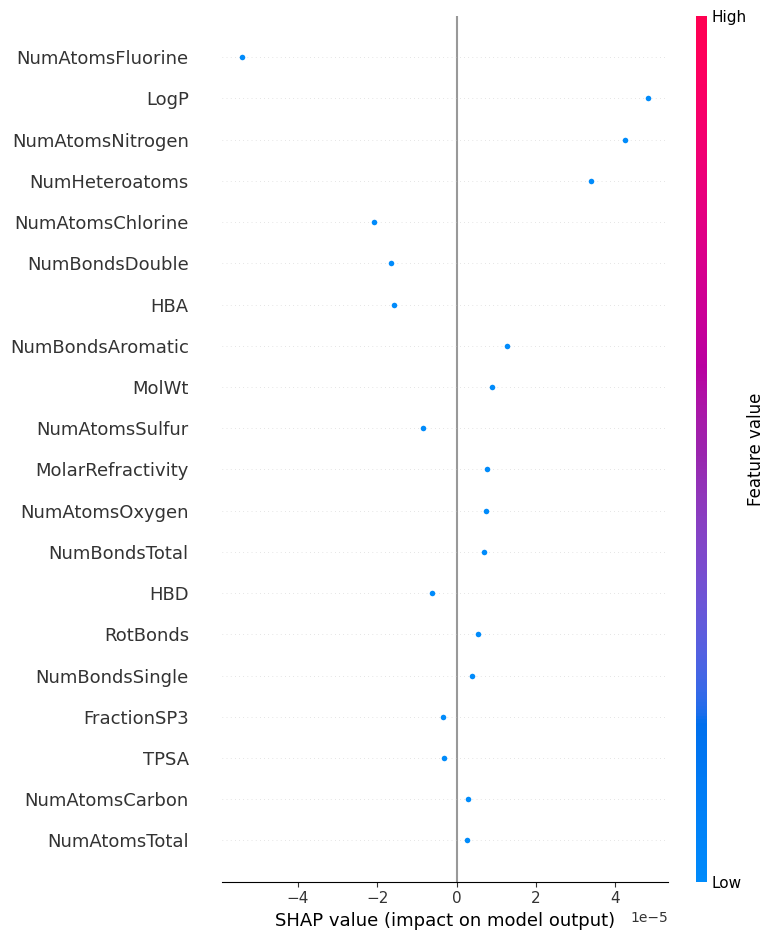

In [ ]:
# Import releveant tools

import shap

# Predict new molecules
new_predictions = best_XGB_model.predict(new_features)

for name, pred in zip(new_features.index, new_predictions):
    print(f"{name}: Predicted activity = {pred}")

xgb_model = best_XGB_model.named_steps['XGB']

# Calculate Shapley values

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(new_features)

# Visulaize SHAP values for each molecule

for i, name in enumerate(new_features.index):
    print(f"\nSHAP values for {name}:")
    shap.summary_plot(shap_values[i:i+1], new_features[i:i+1], feature_names=new_features.columns)



### **Predictions and Shapley Values for New Moelecules**

Both molecules are predicted to be class 0 molecules.
For both molecules, the shapley values are low across all features. Looking at the chemical properties of the moelcules, we can indeed see that they do not have Flourine or Chlorine, and have a realtivly low number of Hetroatoms and Nitrogen atoms, all of which are positive effects in the partial dependence plots.  


10. Calculate the Shapley values for all active molecules in the test set and produce a lowdimensional embedding using t-SNE. Do you
find
that there are clusters of molecules with similar Shapley values? Are they known to have a common mechanism of action? (you are
encouraged to use ChatGPT/GeminiPro/Grok’s DeepResearch for this).

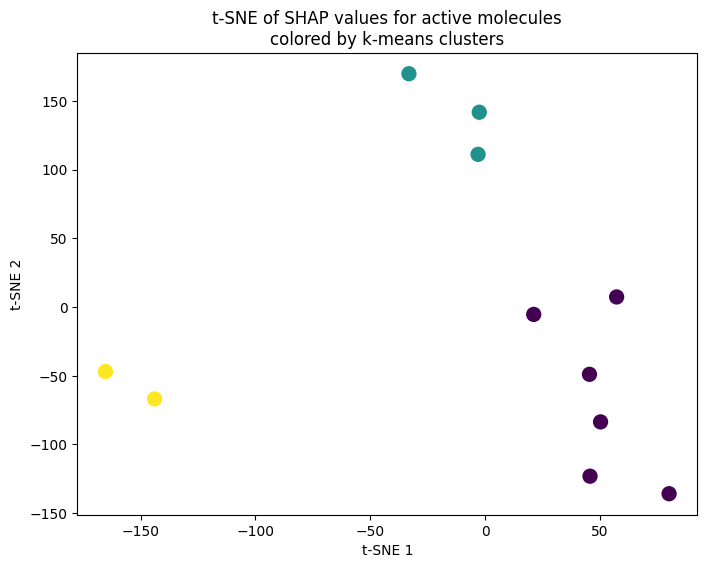

In [ ]:
# Import relevant tools

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Identify active molecules

active_idx = np.where(y_test == 1)[0]
X_active = X_test.iloc[active_idx]

shap_values_active = explainer.shap_values(X_active)

# Run TSNE with K-means clustering

tsne = TSNE(n_components=2, perplexity=3)
shap_tsne = tsne.fit_transform(shap_values_active)

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(shap_tsne)

# Plot with colors by cluster

plt.figure(figsize=(8,6))
scatter = plt.scatter(shap_tsne[:,0], shap_tsne[:,1], c=cluster_labels, s=100)
plt.title("t-SNE of SHAP values for active molecules\ncolored by k-means clusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()


In [ ]:
# Group moleculules by cluster

X_active['cluster'] = cluster_labels
molecules_by_cluster = X_active.groupby('cluster')['cluster'].apply(lambda _: X_active.loc[_.index].index.tolist())

for i, molecules in molecules_by_cluster.items():
    print(f'Cluster #{i+1}:')
    print(f'{molecules}\n')


Cluster #1:
['AZACITIDINE', 'CHLOROXINE', 'DIAVERIDINE', 'NITROFURANTOIN', 'NITROXOLINE', 'RONNEL']

Cluster #2:
['DEMECLOCYCLINE HYDROCHLORIDE', 'RIFAMPIN', 'TOBRAMYCIN']

Cluster #3:
['CLINAFOXACIN HYDROCHLORIDE', 'NORFLOXACIN']



### **Common Mechanisms of Action**

According to chatgpt, the common mechanism of action among molecules in each cluster is:

- cluster 1: Mostly antibacterial agents targeting bacterial DNA or metabolic enzymes.

- cluster 2: Antibiotics that inhibit bacterial RNA or protein synthesis.

- cluster 3: Fluoroquinolone antibiotics targeting bacterial DNA replication enzymes.

# Part V: Training a Graph Neural Network

To train a GNN, we first create a graph-based representation of each molecule suitable for processing it with GNNs. Here, each node correspond to one heavy atom (excluding hydrogen atoms), and each edge to a covalent bond.

We have per-node features (atom type, etc.) and per-edge features (covalent bond type).  These can be summarized as:

- A node feature matrix $F$, of size Number of atoms by Number of feature nodes.
- An edge feature matrix $F_E$, of size Number of edges by Number of feature nodes.
- An edge indices matrix $E$, of size Number of edges by 2 ($E_{k1},E_{k2}$ are the indices of the incoming and outgoing node for edge k).

In [ ]:
import torch


def molecule_to_graph(mol):
    """
    Convert a RDKIT Molecule object into a graph-based representation.

    Parameters:
    smiles (str): SMILES string of the molecule.

    Returns:
    - node_features: List of feature vectors for each atom.
    - edge_index: List of [source, target] pairs representing bonds.
    - edge_features: List of feature vectors for each bond.
    """

    atom_types = ['C','O','N','S','F','Cl','Br','P']
    hybridization_types = list(Chem.rdchem.HybridizationType.values.values())


    def ont_hot_encoding(symbol,symbols):
      nsymbols = len(symbols)
      idx = symbols.index(symbol) if symbol in symbols else nsymbols
      one_hot = torch.zeros(nsymbols+1)
      one_hot[idx] = 1
      return one_hot


    # Define node feature extraction
    def get_atom_features(atom):
        """
        Extract features for a single atom.

        Per-atom features:





        """
        all_features =  torch.concatenate([
            ont_hot_encoding(atom.GetSymbol() , atom_types  ), # Heavy atom type
            ont_hot_encoding(atom.GetHybridization() , hybridization_types  ), # Electronic orbital type (Sp3, Sp2...)
            torch.tensor([atom.GetDegree()]),                # Number of bonds
            torch.tensor([atom.GetFormalCharge()]),          # Formal charge
            torch.tensor([atom.GetTotalNumHs()]),            # Number of hydrogen atoms attached to it.
            torch.tensor([atom.IsInRing()])      # Is the atom in a ring? (1 or 0)

        ]).to(torch.float32)
        return all_features


    # Define edge feature extraction
    def get_bond_features(bond):
        """
        Extract features for a single bond.
        Returns a list of features: [is_single, is_double, is_triple, is_aromatic, is_conjugated]
        """
        bond_type = bond.GetBondType()
        return [
            1 if bond_type == Chem.BondType.SINGLE else 0,
            1 if bond_type == Chem.BondType.DOUBLE else 0,
            1 if bond_type == Chem.BondType.TRIPLE else 0,
            1 if bond_type == Chem.BondType.AROMATIC else 0,
            1 if bond.GetIsConjugated() else 0
        ]


    # Initialize lists for graph components
    node_features = [get_atom_features(atom) for atom in mol.GetAtoms()]  # Extract node features for each atom

    edge_features = []
    edge_index = []

    # Extract edge features and connectivity
    for bond in mol.GetBonds():
        start_idx = bond.GetBeginAtomIdx()
        end_idx = bond.GetEndAtomIdx()
        # Add edges in both directions (undirected graph)
        edge_index.append([start_idx, end_idx])
        edge_index.append([end_idx, start_idx])
        # Add bond features for both directions
        bond_feats = get_bond_features(bond)
        edge_features.append(bond_feats)
        edge_features.append(bond_feats)

    # Convert to torch tensors
    node_features = torch.stack(node_features,axis=0)
    if len(edge_features)==0:
      print(mol,'This molecule has no edges!')
      edge_features = torch.zeros([0, 5],dtype=torch.float32)
      edge_index = torch.zeros([0, 2],dtype=torch.int64)
    else:
      edge_features = torch.tensor(edge_features,dtype=torch.float32)
      edge_index = torch.tensor( edge_index, dtype=torch.int64)  # Shape: [num_edges,2]
    return node_features,edge_features,edge_index



first_round_molecules_graph = [molecule_to_graph(mol) for mol in first_round_molecules_rdkit]
evaluation_molecules_graph = [molecule_to_graph(mol) for mol in evaluation_molecules_rdkit]



print('Example of graph representation for one molecules')

print('Node features shape',first_round_molecules_graph[0][0].shape)
print( first_round_molecules_graph[0][0] )

print('Edge features shape',first_round_molecules_graph[0][1].shape)
print( first_round_molecules_graph[0][1] )


print('Edge indices shape',first_round_molecules_graph[0][2].shape)
print( first_round_molecules_graph[0][2] )


<rdkit.Chem.rdchem.Mol object at 0x7f323047b3e0> This molecule has no edges!
<rdkit.Chem.rdchem.Mol object at 0x7f32303d7df0> This molecule has no edges!
Example of graph representation for one molecules
Node features shape torch.Size([42, 23])
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 1., 0., 3., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 3., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 2., 0., 1., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 3., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 1., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 3., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        

# Inmplementing a Graph Convolution Network using PyTorch Geometric

This implementation is adapted from https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing#scrollTo=0gZ-l0npPIca

I recommend to go over this notebook first.


## Step 1: Convert data into PyTorch Geometric Dataset

In [ ]:
import torch
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader

# Custom Dataset class
class CustomGraphDataset(Dataset):
    def __init__(self, graph_triplets, graph_labels=None, transform=None, pre_transform=None):
        super(CustomGraphDataset, self).__init__(transform=transform, pre_transform=pre_transform)
        self.data_list = self._process_examples(graph_triplets,graph_labels=graph_labels)

    def _process_examples(self, graph_triplets,graph_labels=None):
      N = len(graph_triplets)
      data_list = []
      for n in range(N):
          node_features, edge_features, edge_indices = graph_triplets[n]
          label = torch.tensor( graph_labels[n]) if graph_labels is not None else None

          # Create a Data object for each graph
          data = Data(
              x=node_features,               # Node features
              edge_attr=edge_features,       # Edge features
              edge_index=edge_indices.T,       # Edge indices
              y=label                        # Binary label
          )
          data_list.append(data)
      return data_list

    def len(self):
        """
        Return the number of graphs in the dataset.
        """
        return len(self.data_list)

    def get(self, idx):
        """
        Return the Data object at index idx.
        """
        return self.data_list[idx]



# Create the dataset
dataset = CustomGraphDataset(first_round_molecules_graph, table_first_round_molecules['Class_Label'])

train_dataset = dataset[train_index]
validation_dataset = dataset[val_index]
test_dataset = dataset[test_index]

evaluation_dataset = CustomGraphDataset(evaluation_molecules_graph)

# Create a DataLoader for batching
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
evaluation_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


## Step 2: Define a simple Graph Convolution Network
**Note that here, we don't use the edge features at all.**

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)


        # Initialize the layers
        self.node_embedding = Linear(dataset.num_node_features, hidden_channels)
        self.conv = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2) # Here, only two classes


    def forward(self, node_features, edge_features, edge_index, batch):

        # 1. Embed node features
        x = self.node_embedding(node_features)
        x = x.relu()

        # 2. Pass through a [permutation-equivariant] GCN layer

        x = self.conv(x, edge_index) # Element-wise non-linearity
        x = x.relu() # Element-wise non-linearity

        # 3. Global average pooling for obtaining a permutation-invariant representation.
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 4. Apply a final classifier
        x = self.lin(x) # This is the pre-sigmoid output.
        return x


model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
print(dataset.num_node_features)

23


# Step 3: Train the model!

*!!! Make sure that you selected the GPU runtype !!* (Runtime -> Change runtime type)

In [ ]:
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_attr, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = loss_function(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()
     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_attr, data.edge_index, data.batch)
         pred = out.argmax(dim=1)  # Most likely output.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 100):
    train()
    train_acc = test(train_loader)
    val_acc = test(validation_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {test_acc:.4f} ,  Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.9440, Val Acc: 0.9368 ,  Test Acc: 0.9368
Epoch: 002, Train Acc: 0.9440, Val Acc: 0.9368 ,  Test Acc: 0.9368
Epoch: 003, Train Acc: 0.9440, Val Acc: 0.9368 ,  Test Acc: 0.9368
Epoch: 004, Train Acc: 0.9440, Val Acc: 0.9368 ,  Test Acc: 0.9368
Epoch: 005, Train Acc: 0.9440, Val Acc: 0.9368 ,  Test Acc: 0.9368
Epoch: 006, Train Acc: 0.9440, Val Acc: 0.9368 ,  Test Acc: 0.9368
Epoch: 007, Train Acc: 0.9440, Val Acc: 0.9368 ,  Test Acc: 0.9368
Epoch: 008, Train Acc: 0.9440, Val Acc: 0.9368 ,  Test Acc: 0.9368
Epoch: 009, Train Acc: 0.9440, Val Acc: 0.9368 ,  Test Acc: 0.9368
Epoch: 010, Train Acc: 0.9440, Val Acc: 0.9368 ,  Test Acc: 0.9368
Epoch: 011, Train Acc: 0.9440, Val Acc: 0.9368 ,  Test Acc: 0.9368
Epoch: 012, Train Acc: 0.9440, Val Acc: 0.9368 ,  Test Acc: 0.9368
Epoch: 013, Train Acc: 0.9440, Val Acc: 0.9368 ,  Test Acc: 0.9368
Epoch: 014, Train Acc: 0.9440, Val Acc: 0.9368 ,  Test Acc: 0.9368
Epoch: 015, Train Acc: 0.9440, Val Acc: 0.9368 ,  Test Acc: 0.

11.	Setting the number of epochs and early stopping.


a.	Modify the code to record the Area Under the Precision Recall Curve (AUCPR) over the train and validation set after each epoch and plot the learning curve (metric vs epoch) for the train and validation set. Adjust the number of epochs until overfitting is observed.

b.	Retrain the same GCN model, but add an early stopping criterion using the AUCPR calculated over the validation set. Report the performance on the test set. How does it compare to the feature-based model?


In [ ]:
from sklearn.metrics import average_precision_score as APS

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_attr, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = loss_function(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()
    y_true = []
    y_scores = []
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_attr, data.edge_index, data.batch)
            probs = torch.softmax(out, dim=1)[:, 1]  # probability for class 1
            y_scores.extend(probs.cpu().numpy())
            y_true.extend(data.y.cpu().numpy())
    return APS(y_true, y_scores)

train_AUCPRs = []
val_AUCPRs = []
test_AUCPRs = []

epochs = 1000
prints = 50

for epoch in range(1, epochs):
    train()
    train_AUCPR = test(train_loader)
    val_AUCPR = test(validation_loader)
    test_AUCPR = test(test_loader)

    train_AUCPRs.append(train_AUCPR)
    val_AUCPRs.append(val_AUCPR)
    test_AUCPRs.append(test_AUCPR)

    if epoch % prints == 0:
        print(f'Epoch: {epoch:03d}, Train AUCPR: {train_AUCPR:.4f}, Val AUCPR: {val_AUCPR:.4f}, Test AUCPR: {test_AUCPR:.4f}')

Epoch: 050, Train AUCPR: 0.5292, Val AUCPR: 0.4638, Test AUCPR: 0.8315
Epoch: 100, Train AUCPR: 0.6243, Val AUCPR: 0.4817, Test AUCPR: 0.8488
Epoch: 150, Train AUCPR: 0.5658, Val AUCPR: 0.6074, Test AUCPR: 0.8190
Epoch: 200, Train AUCPR: 0.7018, Val AUCPR: 0.5882, Test AUCPR: 0.8520
Epoch: 250, Train AUCPR: 0.6947, Val AUCPR: 0.6063, Test AUCPR: 0.8654
Epoch: 300, Train AUCPR: 0.7281, Val AUCPR: 0.6485, Test AUCPR: 0.8768
Epoch: 350, Train AUCPR: 0.7388, Val AUCPR: 0.6491, Test AUCPR: 0.8888
Epoch: 400, Train AUCPR: 0.7594, Val AUCPR: 0.6686, Test AUCPR: 0.9002
Epoch: 450, Train AUCPR: 0.7642, Val AUCPR: 0.6220, Test AUCPR: 0.9070
Epoch: 500, Train AUCPR: 0.7711, Val AUCPR: 0.6759, Test AUCPR: 0.9054
Epoch: 550, Train AUCPR: 0.7785, Val AUCPR: 0.6169, Test AUCPR: 0.8991
Epoch: 600, Train AUCPR: 0.8037, Val AUCPR: 0.6313, Test AUCPR: 0.9194
Epoch: 650, Train AUCPR: 0.8064, Val AUCPR: 0.6372, Test AUCPR: 0.9083
Epoch: 700, Train AUCPR: 0.8078, Val AUCPR: 0.6232, Test AUCPR: 0.9171
Epoch:

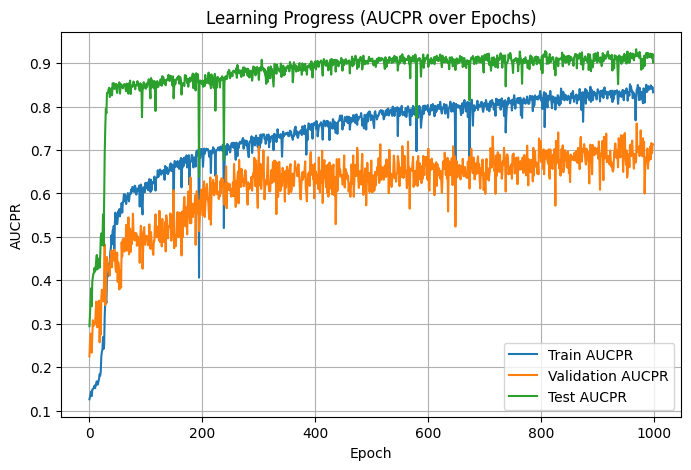

In [ ]:
# Plot for visualization of learning progress

plt.figure(figsize=(8,5))
plt.plot(train_AUCPRs, label='Train AUCPR')
plt.plot(val_AUCPRs, label='Validation AUCPR')
plt.plot(test_AUCPRs, label='Test AUCPR')
plt.xlabel('Epoch')
plt.ylabel('AUCPR')
plt.title('Learning Progress (AUCPR over Epochs)')
plt.legend()
plt.grid(True)
plt.show()

### **Notes:**

In the above plot we don't really observe any significant overfitting. Other times I ran the model it started to overfitt around 700 iterations. For computational purposes, I will truncate the model at 1000 iterations, whether we will reach the early stopping criterion or not. I set the model to stop if for 100 epochs, we don't obatain an increase in performance (compared to the best observed performance) on validation.

In [ ]:
# Import relevant tools

import copy

# Early stopping parameters

patience = 100
best_val_AUCPR = 0
epochs_without_improvement = 0
best_model_state = None

train_AUCPRs = []
val_AUCPRs = []
test_AUCPRs = []

epochs = 1000
prints = 50

for epoch in range(1, epochs):
    train()
    train_AUCPR = test(train_loader)
    val_AUCPR = test(validation_loader)
    test_AUCPR = test(test_loader)

    train_AUCPRs.append(train_AUCPR)
    val_AUCPRs.append(val_AUCPR)
    test_AUCPRs.append(test_AUCPR)

    # Check for validation improvement

    if val_AUCPR > best_val_AUCPR:
        best_val_AUCPR = val_AUCPR
        epochs_without_improvement = 0
        best_model_state = copy.deepcopy(model.state_dict())  # Save model

    else:
        epochs_without_improvement += 1

    if epoch % prints == 0:
        print(f'Epoch: {epoch:03d}, Train AUCPR: {train_AUCPR:.4f}, Val AUCPR: {val_AUCPR:.4f}, Test AUCPR: {test_AUCPR:.4f}')

    # Early stopping condition
    if epochs_without_improvement >= patience:
        print(f"\nEarly stop at epoch {epoch}. \nCurrent AUCPRs: \nTraining - {train_AUCPR:.4f} \nValidation - {val_AUCPR:.4f} \nTest - {test_AUCPR:.4f}")
        break

Epoch: 050, Train AUCPR: 0.8906, Val AUCPR: 0.6653, Test AUCPR: 0.9185
Epoch: 100, Train AUCPR: 0.8845, Val AUCPR: 0.7168, Test AUCPR: 0.9054
Epoch: 150, Train AUCPR: 0.8995, Val AUCPR: 0.7222, Test AUCPR: 0.8989

Early stop at epoch 156. 
Current AUCPRs: 
Training - 0.8988 
Validation - 0.6829 
Test - 0.9310


### **Comparison of results**

Using early stopping, we obtain a test AUCPR of 0.931, which is indeed much better than the AUCPR we obtined using xgboost (0.558).

12.	How many parameters does the GCN have, as function of the number of layers and of the dimension of the node features?

Lets define the number of layers as $L$ and the dimension of the node features by $d$. Also denote the hidden dimension by $h$.

Then we have a total of $(hd+h) + L(h^2+h) + (2h + 2)$ parameters, where:

- $(hd+h)$ is the number of parameters in the embedding layer.
- $(h^2+h)$ is the number of parameters in each convolutional layer.
- $(2h + 2)$ is the number of parameters in the classification head.

Then, our total can be re-written as:

$$
(hd+h) + L(h^2+h) + (2h + 2) \\
= h(d+1) + Lh(h+1) + 2h + 2 \\
=  h(d + 1 + L(h+1) + 2) + 2  \\
= h(d + 3 + L(h+1)) + 2
$$




13.	Varying the network width: Train GCNs with varying node feature dimensions ([16,32,64,128] ) and plot the learning curves of the model (loss vs number of epochs) on the training and validation sets. Are there signs of overfitting? Why?



Our data has 23 node feature dimension. We can vary the node feature dimension by changing the number of hidden layers.
I ran each dimension size for 300 epochs.


GCN with node feature dimension: 16

Epoch #100: Training loss - 0.1480, Validation loss - 0.1782
Epoch #200: Training loss - 0.1276, Validation loss - 0.1913


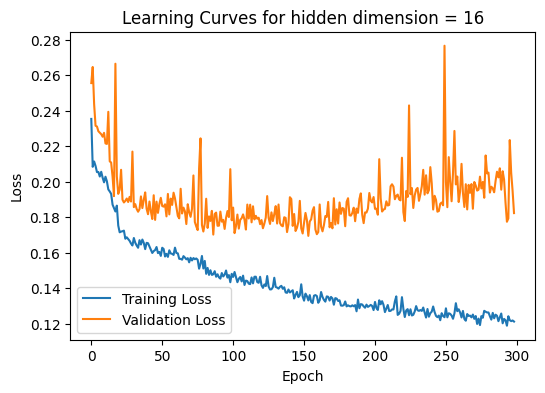


GCN with node feature dimension: 32

Epoch #100: Training loss - 0.1488, Validation loss - 0.2191
Epoch #200: Training loss - 0.1107, Validation loss - 0.1844


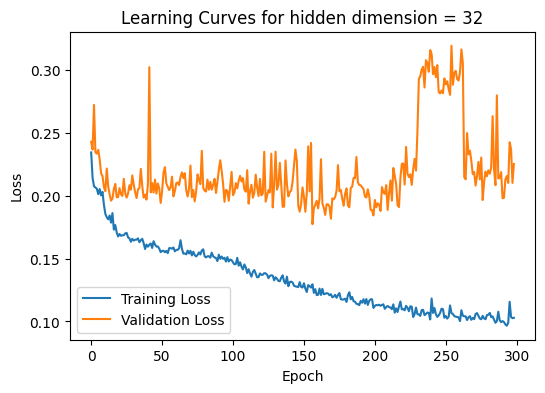


GCN with node feature dimension: 64

Epoch #100: Training loss - 0.1228, Validation loss - 0.2137
Epoch #200: Training loss - 0.1022, Validation loss - 0.2448


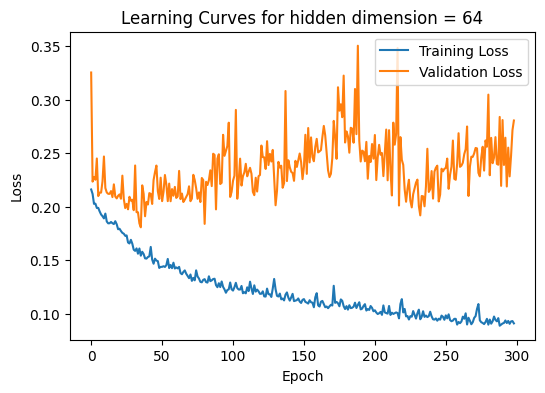


GCN with node feature dimension: 128

Epoch #100: Training loss - 0.1237, Validation loss - 0.1776
Epoch #200: Training loss - 0.1136, Validation loss - 0.2094


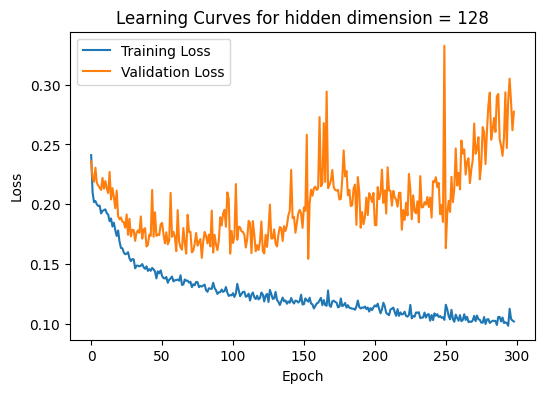

In [ ]:
# Updated the code to record the loss and to update the hidden layer

node_features_dims = [16, 32, 64, 128]

for node_features_dim in node_features_dims:

  print(f'\nGCN with node feature dimension: {node_features_dim}\n')

  model = GCN(hidden_channels=node_features_dim)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  loss_function = torch.nn.CrossEntropyLoss()

  def train():
    model.train()
    total_loss = 0
    count = 0
    for data in train_loader:
        out = model(data.x, data.edge_attr, data.edge_index, data.batch)
        loss = loss_function(out, data.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item() * data.num_graphs # Updated to return the loss
        count += data.num_graphs
    return total_loss / count


  def validation_loss():
    model.eval()
    total_loss = 0
    count = 0
    with torch.no_grad():
        for data in validation_loader:
            out = model(data.x, data.edge_attr, data.edge_index, data.batch)
            loss = loss_function(out, data.y)
            total_loss += loss.item() * data.num_graphs
            count += data.num_graphs
    return total_loss / count

  epochs = 300
  prints = 100

  train_losses = []
  val_losses = []

  for epoch in range(1, epochs):
    avg_train_loss = train()
    avg_val_loss = validation_loss()

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    if epoch % prints == 0:
      print(f'Epoch #{epoch}: Training loss - {avg_train_loss:.4f}, Validation loss - {avg_val_loss:.4f}')

  # Plot for each dimension size

  plt.figure(figsize=(6,4))
  plt.plot(train_losses, label='Training Loss')
  plt.plot(val_losses, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(f'Learning Curves for hidden dimension = {node_features_dim}')
  plt.legend()
  plt.show()


All models exhibit significant overfitting beginning around 100 to 150 epochs. Based on visual inspection, a node feature dimension of 16 appears to perform best. As the number of hidden layers increases, overfitting becomes more extreme. This is intuitive, as additional hidden layers increase model complexity (i.e., more parameters), enabling the model to learn the training data more intricately. However, in this case, the added complexity does not seem beneficial—instead, it causes the model to overfit to the training data, resulting in poorer performance on the validation set.

14.	Varying the network depth and the oversmoothing effect: Train GCNs with varying number of layers ([1, 3,5,10]), and (approximately) fixed number of parameters, and plot the learning curves of the model. Are there signs of overfitting? Underfitting? Why?


GCN with 1 layers

Epoch #100: Training loss - 0.1228, Validation loss - 0.2137
Epoch #200: Training loss - 0.1022, Validation loss - 0.2448


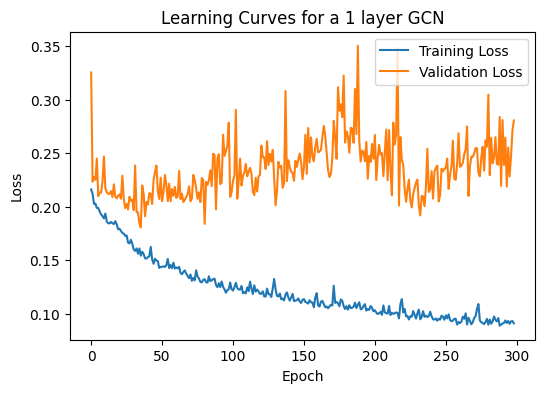


GCN with 3 layers

Epoch #100: Training loss - 0.1142, Validation loss - 0.6055
Epoch #200: Training loss - 0.1288, Validation loss - 0.1878


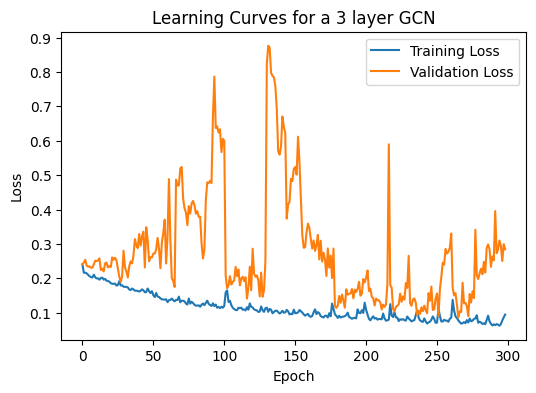


GCN with 5 layers

Epoch #100: Training loss - 0.1624, Validation loss - 0.4155
Epoch #200: Training loss - 0.2092, Validation loss - 0.6505


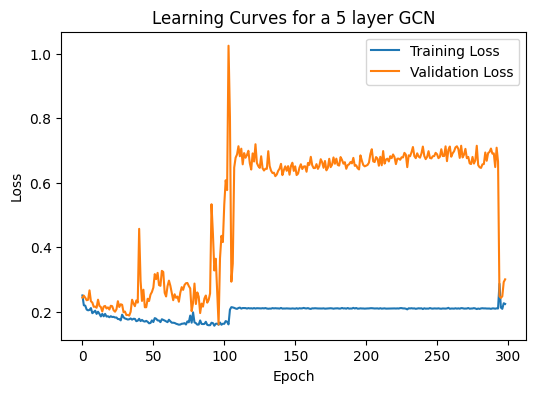


GCN with 10 layers

Epoch #100: Training loss - 0.2118, Validation loss - 0.2502
Epoch #200: Training loss - 0.2118, Validation loss - 0.2497


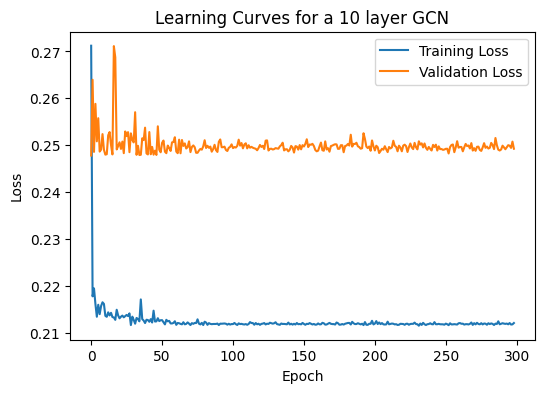

In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool

# Updated GCN class

class GCN(torch.nn.Module):

    def __init__(self, hidden_channels, num_layers): # Update to take in number of layers
        super(GCN, self).__init__()
        torch.manual_seed(12345)

        # Initialize the layers
        self.node_embedding = Linear(dataset.num_node_features, hidden_channels)
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(hidden_channels, hidden_channels))  # First GCN layer

        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))  # Hidden layers

        self.lin = Linear(hidden_channels, 2)

    def forward(self, node_features, edge_features, edge_index, batch):

        # 1. Embed node features
        x = self.node_embedding(node_features)
        x = F.relu(x)

        # 2. Updtaed for multiple layers
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)

        # 3. Global average pooling for obtaining a permutation-invariant representation
        x = global_mean_pool(x, batch) # [batch_size, hidden_channels]

        # 4. Apply a final classifier
        x = self.lin(x) # This is the pre-sigmoid output.
        return x

Layers = [1, 3, 5, 10]

for layer in Layers:

  print(f'\nGCN with {layer} layers\n')

  model = GCN(hidden_channels=64, num_layers=layer+1)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  loss_function = torch.nn.CrossEntropyLoss()

  def train():
    model.train()
    total_loss = 0
    count = 0
    for data in train_loader:
        out = model(data.x, data.edge_attr, data.edge_index, data.batch)
        loss = loss_function(out, data.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item() * data.num_graphs # Updated to return the loss
        count += data.num_graphs
    return total_loss / count


  def validation_loss():
    model.eval()
    total_loss = 0
    count = 0
    with torch.no_grad():
        for data in validation_loader:
            out = model(data.x, data.edge_attr, data.edge_index, data.batch)
            loss = loss_function(out, data.y)
            total_loss += loss.item() * data.num_graphs
            count += data.num_graphs
    return total_loss / count

  epochs = 300
  prints = 100

  train_losses = []
  val_losses = []

  for epoch in range(1, epochs):
    avg_train_loss = train()
    avg_val_loss = validation_loss()

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    if epoch % prints == 0:
      print(f'Epoch #{epoch}: Training loss - {avg_train_loss:.4f}, Validation loss - {avg_val_loss:.4f}')

  # Plot for each dimension size

  plt.figure(figsize=(6,4))
  plt.plot(train_losses, label='Training Loss')
  plt.plot(val_losses, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(f'Learning Curves for a {layer} layer GCN')
  plt.legend()
  plt.show()



There are indications of both overfitting and underfitting in these results. Among the models, the 3-layer GCN appears to perform the best. Increasing the number of convolutional layers allows the model to aggregate information from more distant nodes in the graph, which can be beneficial to a point. In this case, increasing from 1 to 3 layers improves performance, but going beyond 3 layers seems to introduce excessive complexity and may decrease performance.

15.	Virtual screening: Pick the best GNN, and use it to predict antimicrobial activity on the evaluation set. How do the predictions correlate with the ones of the D-MPNN model? Does it predict halicin to have an activity?

Based on the previous results, I will use A GCN with 3 layers and node features dimension 16. I will let it run for 1000 iterations and plot the performance on training, validation and test (w.r.t AUCPR), to examine the performance.

In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool

# Updated GCN class

class GCN(torch.nn.Module):

    def __init__(self, hidden_channels, num_layers): # Update to take in number of layers
        super(GCN, self).__init__()
        torch.manual_seed(12345)

        # Initialize the layers
        self.node_embedding = Linear(dataset.num_node_features, hidden_channels)
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(hidden_channels, hidden_channels))  # First GCN layer

        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))  # Hidden layers

        self.lin = Linear(hidden_channels, 2)

    def forward(self, node_features, edge_features, edge_index, batch):

        # 1. Embed node features
        x = self.node_embedding(node_features)
        x = F.relu(x)

        # 2. Updtaed for multiple layers
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)

        # 3. Global average pooling for obtaining a permutation-invariant representation
        x = global_mean_pool(x, batch) # [batch_size, hidden_channels]

        # 4. Apply a final classifier
        x = self.lin(x) # This is the pre-sigmoid output.
        return x

In [ ]:
# Import relevant tools

from sklearn.metrics import average_precision_score as APS
import copy

model = GCN(hidden_channels=16, num_layers=3+1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_function = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    total_loss = 0
    count = 0
    for data in train_loader:
        out = model(data.x, data.edge_attr, data.edge_index, data.batch)
        loss = loss_function(out, data.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item() * data.num_graphs # Updated to return the loss
        count += data.num_graphs
    return total_loss / count

def test(loader):
    model.eval()
    y_true = []
    y_scores = []
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_attr, data.edge_index, data.batch)
            probs = torch.softmax(out, dim=1)[:, 1]  # probability for class 1
            y_scores.extend(probs.cpu().numpy())
            y_true.extend(data.y.cpu().numpy())
    return APS(y_true, y_scores)

def validation_loss():
  model.eval()
  total_loss = 0
  count = 0
  with torch.no_grad():
      for data in validation_loader:
          out = model(data.x, data.edge_attr, data.edge_index, data.batch)
          loss = loss_function(out, data.y)
          total_loss += loss.item() * data.num_graphs
          count += data.num_graphs
  return total_loss / count

train_AUCPRs = []
val_AUCPRs = []
test_AUCPRs = []
train_losses = []
val_losses = []

epochs = 1000
prints = 100

for epoch in range(1, epochs):
    avg_train_loss = train()
    avg_val_loss = validation_loss()

    train_AUCPR = test(train_loader)
    val_AUCPR = test(validation_loader)
    test_AUCPR = test(test_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    train_AUCPRs.append(train_AUCPR)
    val_AUCPRs.append(val_AUCPR)
    test_AUCPRs.append(test_AUCPR)

    if epoch % prints == 0:
        print(f'Epoch: {epoch:03d}, Train AUCPR: {train_AUCPR:.4f}, Train Loss: {avg_train_loss}, Val AUCPR: {val_AUCPR:.4f}, Val Loss: {avg_val_loss}')

Epoch: 100, Train AUCPR: 0.6342, Train Loss: 0.1319267082596841, Val AUCPR: 0.4828, Val Loss: 0.20802217212605612
Epoch: 200, Train AUCPR: 0.6853, Train Loss: 0.11652309781544387, Val AUCPR: 0.6234, Val Loss: 0.20265067852823074
Epoch: 300, Train AUCPR: 0.7381, Train Loss: 0.10976114051920924, Val AUCPR: 0.6217, Val Loss: 0.44862123616671157
Epoch: 400, Train AUCPR: 0.7575, Train Loss: 0.1351225119642068, Val AUCPR: 0.5801, Val Loss: 0.47405979167249074
Epoch: 500, Train AUCPR: 0.7762, Train Loss: 0.09332711433318307, Val AUCPR: 0.6545, Val Loss: 0.5186659058734859
Epoch: 600, Train AUCPR: 0.7746, Train Loss: 0.08750427377551599, Val AUCPR: 0.5978, Val Loss: 1.3164302755297177
Epoch: 700, Train AUCPR: 0.8244, Train Loss: 0.08463284785662502, Val AUCPR: 0.6172, Val Loss: 1.1266016050552328
Epoch: 800, Train AUCPR: 0.7930, Train Loss: 0.0866651935892699, Val AUCPR: 0.7188, Val Loss: 2.666840458187501
Epoch: 900, Train AUCPR: 0.8280, Train Loss: 0.08500353243733619, Val AUCPR: 0.6230, Val

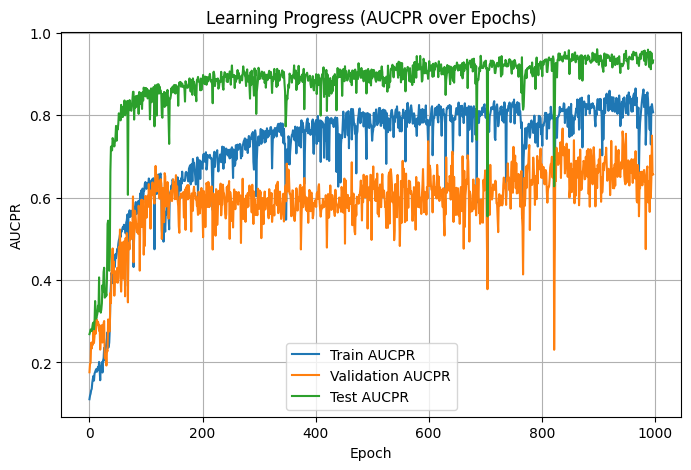

In [ ]:
# Plot for visualization of learning progress

plt.figure(figsize=(8,5))
plt.plot(train_AUCPRs[1:1300], label='Train AUCPR')
plt.plot(val_AUCPRs[1:1300], label='Validation AUCPR')
plt.plot(test_AUCPRs[1:1300], label='Test AUCPR')
plt.xlabel('Epoch')
plt.ylabel('AUCPR')
plt.title('Learning Progress (AUCPR over Epochs)')
plt.legend()
plt.grid(True)
plt.show()

The performance w.r.t AUCPR is very similar to the GCN with a single convolutional layer and hidden layer = 64 (perhaps the original GCN was even better). In either case we obtain very good performance on the test set. We can now attempt to predict the evaluation molecules.

In [ ]:
from scipy.stats import spearmanr

model.eval()

gnn_preds = []
d_mpnn_preds = []

# Loop over the evaluation dataset directly (not the loader)
for i in range(len(evaluation_loader.dataset)):
    graph_data = evaluation_loader.dataset[i]

    # Unsqueeze batch if missing, or add batch attribute for a single graph
    if not hasattr(graph_data, 'batch'):
        graph_data.batch = torch.zeros(graph_data.x.size(0), dtype=torch.long)

    with torch.no_grad():
        out = model(graph_data.x, graph_data.edge_attr, graph_data.edge_index, graph_data.batch)
        prob = torch.nn.functional.softmax(out, dim=-1)[0, 1].item()  # Class 1 prob for single graph
        gnn_preds.append(prob)

    # D-MPNN prediction from your DataFrame (make sure indexing matches!)
    d_mpnn_pred = table_evaluation_molecules.iloc[i]['Pred_Score']
    d_mpnn_preds.append(d_mpnn_pred)

# Convert to numpy arrays for correlation

gnn_preds = np.array(gnn_preds)
d_mpnn_preds = np.array(d_mpnn_preds)

# Calculate Spearman correlation

spearman_corr, _ = spearmanr(gnn_preds, d_mpnn_preds)
print(f"Spearman correlation: {spearman_corr:.4f}")

Spearman correlation: 0.4750


We obtain a Spearman correlation coefficient of 0.475. We can now check the model prediction for Halicin

In [ ]:
# Define Halicin and convert to RDKit Mol

Halicin = {'Halicin': 'Nc1nnc(SCc2nccs2)s1'}
Halicin_rdkit = {name: Chem.MolFromSmiles(smiles) for name, smiles in Halicin.items()}

# Convert Halicin to graph format an PyTorch object

halicin_triplet = molecule_to_graph(Halicin_rdkit['Halicin'])

node_features, edge_features, edge_index = halicin_triplet
halicin_graph = Data(
    x=node_features,
    edge_attr=edge_features,
    edge_index=edge_index.T,
    y=None
)

# Predict Halicin

model.eval()
with torch.no_grad():
    output = model(halicin_graph.x, halicin_graph.edge_attr, halicin_graph.edge_index, halicin_graph.batch)
    prob = F.softmax(output, dim=-1)[0, 1].item()  # Assuming binary classification: class 1 = "active"

print(f"\n Predicted probability of Halicin being active: {prob:.4f}")


 Predicted probability of Halicin being active: 0.9999


We can see that the model is extremely confident in classifying Halicin as an active (class 1) molecule. This as apposed to the xgboost model, which classified it as an inactive (class 0) molecule.   